# Final Pitchbook - Buy Rough, Sell Smooth

- Based on the paper of the same name by Paul Glasserman, Pu He (December 2018)

### Team Members: Aadi Gupta, Mahima Raut, Pravallika Reddy, Rajdeep Das, Roshan Surabhi

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import statsmodels.api as sm
import warnings
from scipy.linalg import eigh
warnings.filterwarnings(action='ignore')
import quandl
import requests
import json
import datetime
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

# Introduction

# Implementation of H values / Technical Work

## Realized Roughness

### Theory of implementation

### Fractional Brownian Motion
- Rough models of stochastic volatility replace an ordinary Brownian motion driving the dynamics of volatility with a fractional 
Brownian motion (fBM). 
- The fBM family, indexed by a single parameter, includes ordinary Brownian motion and also processes with smoother and rougher paths.
- A fractional Brownian motion with Hurst parameter $H ∈ (0, 1)$ is a mean-zero Gaussian process ${W_t^H , −∞ < t < ∞}$ with stationary increments and covariance function given by
$$
\mathbb{E} \big[ W^H (t) W^H (s) \big] = \frac{1}{2} \Big( |t|^{2H} + |s|^{2H} - |t - s|^{2H} \Big)  \quad\quad -(1)
$$

- The case $H = 1/2$ corresponds to ordinary Brownian motion. With $H ∈ (1/2,1)$, fractional Brownian motion exhibits long-range dependence; processes with $H ∈ (0, 1/2)$ have paths that are rougher than those of ordinary Brownian motion, with small H indicating greater roughness.
- We have the following property of the moments of the increments of fractional Brownian motion. For any $t ∈ R$, and $∆ ≥ 0$, and any $q > 0$,
$$
\mathbb{E} \big[ |W^H_{t+\Delta} - W^H_t|^q \big] = \mathbb{E} \big[ |Z|^q \big] \Delta^ {qH}, 
\quad Z \sim N(0,1)  \quad\quad -(2)
$$

- With smaller H, increments over a short interval ∆ have larger moments.



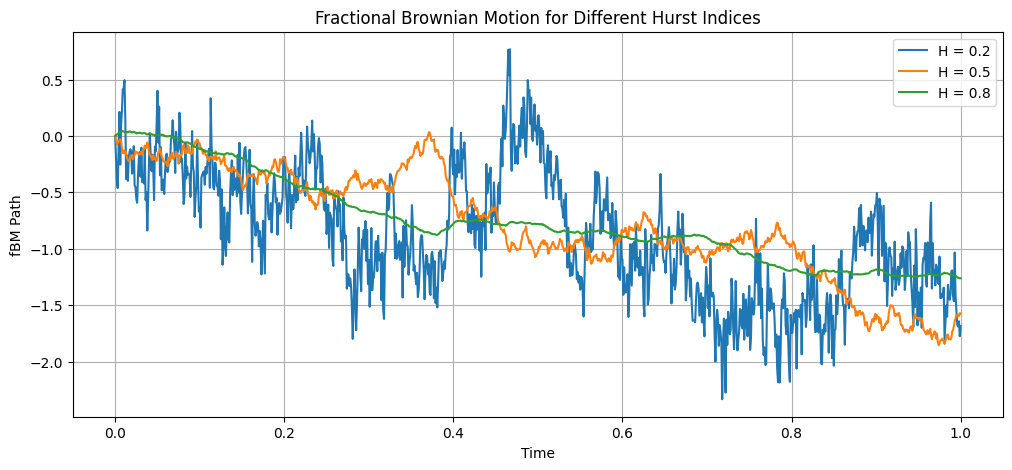

In [2]:
def fbm(T, N, H):
    dt = T / N
    t = np.linspace(0, T, N+1)
    gamma = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(N+1):
            gamma[i, j] = 0.5 * (abs(i * dt)**(2*H) + abs(j * dt)**(2*H) - abs((i-j) * dt)**(2*H))
    eigvals, eigvecs = eigh(gamma)
    eigvals = np.maximum(eigvals, 0) 
    L = eigvecs @ np.diag(np.sqrt(eigvals))
    np.random.seed(42)
    Z = np.random.randn(N+1)
    W = np.dot(L, Z)
    return t, W
T = 1.0   
N = 1000 
H_values = [0.2, 0.5, 0.8]
plt.figure(figsize=(12, 5))
for H in H_values:
    t, W = fbm(T, N, H)
    plt.plot(t, W, label=f"H = {H}")
plt.xlabel("Time")
plt.ylabel("fBM Path")
plt.title("Fractional Brownian Motion for Different Hurst Indices")
plt.legend()
plt.grid()
plt.show(block=True)

### Rough Volatility Model
- As an example of a rough volatility model for an asset price ${St, t ≥ 0}$, we could set

$$
d \log S_t = \mu \, dt + \sigma_t \, dW_t, \quad \quad - (3)
$$
$$
d \log \sigma_t = \nu \, dW_t^H; \quad \quad -(4)
$$

- Here, $μ, κ, m,$ and $ν$ are constants, $W$ is an ordinary Brownian motion, $W^H$ is a fractional Brownian motion with $H ∈ (0,1/2)$, and $W$ and $W^H$ may be correlated. The parameter $H$ determines the roughness of the volatility process.
- Rough volatility arises from mixing mean-reverting volatility processes with different speeds of mean reversion, driven by an ordinary Brownian motion, including components with arbitrarily fast mean reversion.



### One method of estimating realized H values
- If we could observe logσt at times t = 0,∆,2∆,... for some small ∆ > 0, we could estimate H by estimating the below equation for various values of q > 0, and then applying (2) to extract H 

$$
\mathbb{E} \big[ | \log \sigma_{t+\Delta} - \log \sigma_t |^q \big] \quad\quad - (5)
$$



### Implemented methodology of estimating realized H values
- In practice, $σ_t$ cannot be observed and must be estimated, so we proceed as follows. Using trades from the Trade and Quote (TAQ) data, we estimate the daily integrated variance of returns; taking the square root yields our estimated daily volatility.

- The rest of the estimation procedure works with these daily volatilities, which we write as $σ_d$, with $d$ indexing days. We apply (5) with $q = 2$, estimating second moments over intervals of ℓ days, ℓ= 1,2,...,10. In each month, for each stock and each lag ℓ, we calculate (T is the number of days in the month):
$$
z_2(\ell) = \frac{1}{T - \ell} \sum_{d=1}^{T - \ell} \big( \log \hat{\sigma}_{d+\ell} - \log \hat{\sigma}_d \big)^2, \quad\quad -(6)
$$

- Based on (2), we expect
$$
z_2(\ell) \approx \nu^2 \ell^{2H}. \quad\quad -(7)
$$

- So to estimate H we run a regression

$$
\log z_2(\ell) = \beta_1 + \beta_2 \log \ell + \epsilon, \quad\quad -(8)
$$
- We estimate H as $β_2/2$. We also estimate the volatility of volatility $ν$ by setting $log ν = β_1/2$. This procedure yields an estimate of $H$ (and $ν$) for each stock in each month.


### Data import and cleaning

#### Total universe 

- We considered 11 major industries with 10 largest constituent stocks by index weight (as of 31 Dec 2024, src:CRSP) each:

    - US Consumer Discretionary : 	AMZN  TSLA  HD  WMT  MCD  BKNG  LOW  TJX  UBER  SBUX
    - US Consumer Staples : 		COST  PG  KO  PEP  PM  MO  MDLZ  CL  KMB  KVUE
    - US Energy :   			XOM  CVX  COP  EOG  WMB  OKE  SLB  KMI  PSX  LNG
    - US Financials : 			BRK.A/BRK.B  JPM  V  MA  BAC  WFC  GS  SPGI  MS  AXP
    - US Healthcare :			LLY  UNH  JNJ  ABBV  MRK  TMO  ABT  ISRG  PFE  DHR
    - US Industrials :			ACN  CAT  GE  RTX  HON  UNP  BA  ETN  ADP  LMT
    - US Materials :			LIN  SHW  APD  ECL  FCX  NEM  VMC  MLM  DD  DOW
    - US Media & Communications :  	GOOGL  META  NFLX  DIS  T  VZ  CMCSA  TMUS  EA  RBLX
    - US Real Estate & REITs :		PLD  EQIX  AMT  WELL  DLR  SPG  PSA  O  CBRE  CCI
    - US Technology : 			AAPL  MSFT  NVDA  AVGO  CRM  ORCL  NOW  CSCO  IBM  AMD
    - US Utilities :				NEE  SO  DUK  CEG  SRE  AEP  VST  D  PCG  PEG

In [3]:
industries = pd.read_csv('./industry.csv')
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.head()

,industry,top_tickers
0,US Consumer Discretionary,AMZN
1,US Consumer Discretionary,TSLA
2,US Consumer Discretionary,HD
3,US Consumer Discretionary,WMT
4,US Consumer Discretionary,MCD


In [4]:
vols = pd.read_csv('daily_vol_series.csv')
vols = vols[vols['SYM_ROOT'] == vols['symbol']]
vols = vols.merge(industries, left_on='SYM_ROOT', right_on='top_tickers', how='inner')
vols = vols[['DATE', 'SYM_ROOT', 'industry', 'ivol_t', 'ivol_q']]
vols = vols[vols['DATE'] <= '2023-08-31']
vols.head()

,DATE,SYM_ROOT,industry,ivol_t,ivol_q
0,2010-01-04,AAPL,US Technology,6.140084e-09,4.300400e-10
1,2010-01-05,AAPL,US Technology,5.997564e-09,3.934783e-10
2,2010-01-06,AAPL,US Technology,5.785301e-09,5.765893e-10
3,2010-01-07,AAPL,US Technology,9.102045e-09,6.425180e-10
4,2010-01-08,AAPL,US Technology,6.838924e-09,5.694237e-10


In [5]:
vols['month'] = pd.to_datetime(vols['DATE']).dt.month
vols['year'] = pd.to_datetime(vols['DATE']).dt.year
vols['ivol_q_log'] = np.log(vols['ivol_q'])

### Calculating $z_2(\ell)$ for $l={1,2,3 \dots 10}$

In [6]:
def moments(df):
    final_dfs = []
    for lag in range(1, 11):
        tmp = df.groupby(['SYM_ROOT', 'industry', 'year', 'month'])['ivol_q_log']\
            .apply(lambda x: (((x - x.shift(lag))**2).sum() / (x.count() - lag)) ).to_frame(f'lag{lag}_mom')
        final_dfs.append(tmp)
    final_df = pd.concat(final_dfs, axis=1)
    return final_df

In [7]:
final = moments(vols)
final.replace([np.inf, -np.inf], np.nan, inplace=True)
final.dropna(inplace=True)
final.head()


lag1_mom   lag2_mom   lag3_mom   lag4_mom  \
SYM_ROOT industry      year month                                               
AAPL     US Technology 2010 1       0.124012   0.171654   0.142317   0.237785   
                            2       0.067225   0.125021   0.179476   0.244710   
                            3       0.177133   0.242053   0.198273   0.162382   
                            4       0.193675   0.272393   0.313740   0.403786   
                            5      15.892976  25.353659  28.885627  29.800796   

                                    lag5_mom   lag6_mom   lag7_mom   lag8_mom  \
SYM_ROOT industry      year month                                               
AAPL     US Technology 2010 1       0.328099   0.400266   0.529878   0.649329   
                            2       0.314723   0.386906   0.497555   0.595319   
                            3       0.257832   0.319519   0.226560   0.246481   
                            4       0.411080   0.405068   0.399077   0.554030   
                            5      15.897322  16.978581  17.957950  19.168883   

                                    lag9_mom  lag10_mom  
SYM_ROOT industry      year month                        
AAPL     US Technology 2010 1       0.675741   0.825034  
                            2       0.644346   0.776623  
                            3       0.261480   0.348716  
                            4       0.698151   0.725557  
                            5      20.298034  22.192187

### Regressing $\log z_2(\ell) = \beta_1 + \beta_2 \log \ell + \epsilon$ to find H

In [8]:
betas = pd.DataFrame(columns=['Betas'], index=final.index)
for idx,_ in final.iterrows():
    y = final.loc[idx].values
    X = np.log(range(1, 11)).reshape(-1,1)
    # X = sm.add_constant(X) # to ensure positive H-vals
    mod = sm.OLS(y, X).fit()
    betas.loc[idx, 'Betas'] = mod.params[0]
betas.reset_index(inplace=True)
betas['Realized_H'] = betas['Betas'] * 0.5
betas.head()

,SYM_ROOT,industry,year,month,Betas,Realized_H
0,AAPL,US Technology,2010,1,0.275441,0.13772
1,AAPL,US Technology,2010,2,0.261588,0.130794
2,AAPL,US Technology,2010,3,0.142099,0.071049
3,AAPL,US Technology,2010,4,0.275366,0.137683
4,AAPL,US Technology,2010,5,11.469401,5.734701


## Implied Volatility Model


### Theory of implementation

The ATM skew exhibits a power law decay at short maturities, with an exponent determined by H. 

$\sigma_{BS}(k, \tau)$ for the Black-Scholes implied volatility of an option with time-to-maturity $\tau$ and log-moneyness $k = \log(K/S)$, where $K$ is the option's strike price and $S$ is the current level of the underlying. The ATM skew at maturity $\tau$ is given by

$$\phi(\tau) = \left| \frac{\partial \sigma_{BS}(k, \tau)}{\partial k} \right|_{k=0}$$



$$\phi(\tau) \approx \text{constant} \times \tau^{H-1/2}, \quad \text{as } \tau \downarrow 0.$$

In other words, the ATM skew exhibits a power law decay at short maturities, with an exponent determined by $H$.


### Methodology

To estimate the parameter $H$ from market data:

1. For each day and each stock, use filtered option data
2. Fit a cubic spline to model implied volatility as a function of log(K/S)
3. Calculate the derivative of the spline at log(K/S) = 0 to obtain the ATM skew ($\phi$)
4. Run a linear regression in log-log space:
  $$\log(\phi) = c + (H - \frac{1}{2})\log(\tau) + \varepsilon$$
5. Add $\frac{1}{2}$ to the estimated slope coefficient to determine the implied Hurst parameter $H$

This approach allows for robust estimation of the roughness parameter $H$ across different assets and time periods.


### Data import and cleaning

In [9]:
PATH_OPTIONS_DATA_1 = r"industry1_6_option.csv"
PATH_OPTIONS_DATA_2 = r"industry6_11.csv"

In [10]:
options_data_1_6 = pd.read_csv(PATH_OPTIONS_DATA_1)
options_data_1_6.head()

,secid,date,days,impl_volatility,impl_strike,cp_flag,ticker,index_flag
0,100972,2010-01-04,10,NaN,0.0,P,ABT,0
1,100972,2010-01-04,10,NaN,0.0,P,ABT,0
2,100972,2010-01-04,10,NaN,0.0,P,ABT,0
3,100972,2010-01-04,10,NaN,0.0,P,ABT,0
4,100972,2010-01-04,10,NaN,0.0,P,ABT,0


### Data Import Process

To fetch options data from OptionsMetrics on WRDS:

1. Connect to WRDS database using the wrds-python package
2. Query the OptionsMetrics database (optionm.opprcd table) to get:
   - Options data from Jan 2010 to Dec 2023
   - Data for specific major tech stocks (AAPL, GOOGL, MSFT, AMZN, META)
3. Convert date fields to datetime format for further processing

The following PostGreSQL queries were used to fetch TAQ and OptionMetrics data from WRDS:

In [11]:
# sql = f"""
#   SELECT 
#       v.date,
#       v.days,
#       v.impl_volatility,
#       v.impl_strike,
#       v.cp_flag,
#       (SELECT n.ticker 
#        FROM optionm_all.optionmnames n 
#        WHERE n.secid = v.secid 
#        LIMIT 1) AS ticker
#   FROM optionm_all.vsurfd{year} v
#   WHERE EXISTS (
#       SELECT 1
#       FROM optionm_all.optionmnames n 
#       WHERE n.secid = v.secid 
#         AND n.ticker IN {tickers_str}
#   )
#   """

The query below is to fetch WRDS OptionMetrics data:


In [12]:

# sql = f"""
#     WITH windowable_nbbo AS (
#         SELECT
#             sym_root AS ticker,
#             date,
#             time_m,
#             time_m_nano,
#             sym_root,
#             qu_cond,
#             best_bid,
#             best_bidsizeshares,
#             best_ask,
#             best_asksizeshares,
#             EXTRACT(HOUR FROM time_m) AS hour_of_day,
#             EXTRACT(MINUTE FROM time_m) AS minute_of_hour,
#             ROW_NUMBER() OVER (
#                 PARTITION BY sym_root, EXTRACT(HOUR FROM time_m), EXTRACT(MINUTE FROM time_m) 
#                 ORDER BY time_m DESC
#             ) AS rownum
#         FROM taqm_{year_str}.complete_nbbo_{date_str} 
#         WHERE sym_root IN {tickers}
#         AND sym_suffix IS NULL
#         AND time_m > '09:30:00' 
#         AND time_m < '16:00:00'
#     )
#     SELECT DISTINCT ON (ticker, date, hour_of_day, minute_of_hour)
#         ticker,
#         date,
#         date + DATE_TRUNC('minute', time_m) + INTERVAL '1 minute' AS window_time,
#         best_bid,
#         best_bidsizeshares,
#         best_ask,
#         best_asksizeshares,
#         time_m AS time_of_last_quote,
#         time_m_nano AS time_of_last_quote_ns
#     FROM windowable_nbbo
#     WHERE rownum = 1
#     """

Saved in csv after pulling the data

The current implementation is designed to process a subset of Options Data 
The goal is to optimize the code so that it can efficiently fetch, process, and analyze options data for multiple tickers across multiple years without excessive computational overhead.

In [13]:
options_data_1_6['date'] = pd.to_datetime(options_data_1_6['date'])
options_data_1_6['expiration'] = options_data_1_6['date'] + pd.to_timedelta(options_data_1_6['days'], unit='D')

In [14]:
import os

def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "Downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="TDynpHNbX5ucpahcz_85"
, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [15]:
prices_eod_primary = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=False)
prices_eod_primary['date'] = pd.to_datetime(prices_eod_primary['date'])
prices_eod_primary.head()

Data file /Users/mahimaraut/Downloads/QUOTEMEDIA/PRICES_20250301.zip size 1674608027 exists already, no need to download


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,JTKWY,2022-03-11,6.1700,7.3200,5.7900,6.72,9440097.0,0.0,1.0,6.1700,7.3200,5.7900,6.72,9440097.0
1,JTKWY,2022-03-10,6.1600,6.1750,5.9350,6.07,2261623.0,0.0,1.0,6.1600,6.1750,5.9350,6.07,2261623.0
2,FG_1,2020-06-01,8.1000,8.3900,8.1000,8.39,3086317.0,0.0,1.0,8.1000,8.3900,8.1000,8.39,3086317.0
3,YTENQ,2024-09-30,0.9514,1.0500,0.9514,1.05,842.0,0.0,1.0,0.9514,1.0500,0.9514,1.05,842.0
4,FLWS,2022-03-09,14.5700,14.9588,14.4100,14.45,662492.0,0.0,1.0,14.5700,14.9588,14.4100,14.45,662492.0


In [16]:
industries = pd.read_csv('industry.csv')
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.rename(columns={'top_tickers': 'tickers'}, inplace=True)
ticker_list = industries['tickers'].tolist()
industries

,industry,tickers
0,US Consumer Discretionary,AMZN
1,US Consumer Discretionary,TSLA
2,US Consumer Discretionary,HD
3,US Consumer Discretionary,WMT
4,US Consumer Discretionary,MCD
...,...,...
105,US Utilities,AEP
106,US Utilities,VST
107,US Utilities,D
108,US Utilities,PCG


In [17]:
options_dict = { ticker : options_data_1_6[options_data_1_6['ticker'] == ticker] for ticker in ticker_list }
# options_dict = {ticker : options_dict[options_dict['ticker'] == ticker] for ticker in ticker_list if ticker in options_dict}

In [18]:
row = options_dict.keys()
row

dict_keys(['AMZN', 'TSLA', 'HD', 'WMT', 'MCD', 'BKNG', 'LOW', 'TJX', 'UBER', 'SBUX', 'COST', 'PG', 'KO', 'PEP', 'PM', 'MO', 'MDLZ', 'CL', 'KMB', 'KVUE', 'XOM', 'CVX', 'COP', 'EOG', 'WMB', 'OKE', 'SLB', 'KMI', 'PSX', 'LNG', 'BRK.A/BRK.B', 'JPM', 'V', 'MA', 'BAC', 'WFC', 'GS', 'SPGI', 'MS', 'AXP', 'LLY', 'UNH', 'JNJ', 'ABBV', 'MRK', 'TMO', 'ABT', 'ISRG', 'PFE', 'DHR', 'ACN', 'CAT', 'GE', 'RTX', 'HON', 'UNP', 'BA', 'ETN', 'ADP', 'LMT', 'LIN', 'SHW', 'APD', 'ECL', 'FCX', 'NEM', 'VMC', 'MLM', 'DD', 'DOW', 'GOOGL', 'META', 'NFLX', 'DIS', 'T', 'VZ', 'CMCSA', 'TMUS', 'EA', 'RBLX', 'PLD', 'EQIX', 'AMT', 'WELL', 'DLR', 'SPG', 'PSA', 'O', 'CBRE', 'CCI', 'AAPL', 'MSFT', 'NVDA', 'AVGO', 'CRM', 'ORCL', 'NOW', 'CSCO', 'IBM', 'AMD', 'NEE', 'SO', 'DUK', 'CEG', 'SRE', 'AEP', 'VST', 'D', 'PCG', 'PEG'])

Skew Analysis

In [19]:
options_dict['UBER']

,secid,date,days,impl_volatility,impl_strike,cp_flag,ticker,index_flag,expiration
43569878,213638,2019-05-16,10,0.557330,48.57762,P,UBER,0,2019-05-26
43569879,213638,2019-05-16,10,0.560278,47.53992,P,UBER,0,2019-05-26
43569880,213638,2019-05-16,10,0.563888,46.72538,P,UBER,0,2019-05-26
43569881,213638,2019-05-16,10,0.567750,46.03078,P,UBER,0,2019-05-26
43569882,213638,2019-05-16,10,0.571196,45.40570,P,UBER,0,2019-05-26
...,...,...,...,...,...,...,...,...,...
60199035,213638,2023-08-31,730,0.431894,45.94319,C,UBER,0,2025-08-30
60199036,213638,2023-08-31,730,0.439786,41.88845,C,UBER,0,2025-08-30
60199037,213638,2023-08-31,730,0.450169,37.63254,C,UBER,0,2025-08-30
60199038,213638,2023-08-31,730,0.463555,32.99751,C,UBER,0,2025-08-30


# Skew Power Law

The ATM skew exhibits a power law decay at short maturities, with an exponent determined by H. 

$\sigma_{BS}(k, \tau)$ for the Black-Scholes implied volatility of an option with time-to-maturity $\tau$ and log-moneyness $k = \log(K/S)$, where $K$ is the option's strike price and $S$ is the current level of the underlying. The ATM skew at maturity $\tau$ is given by

$$\phi(\tau) = \left| \frac{\partial \sigma_{BS}(k, \tau)}{\partial k} \right|_{k=0}$$



$$\phi(\tau) \approx \text{constant} \times \tau^{H-1/2}, \quad \text{as } \tau \downarrow 0.$$

In other words, the ATM skew exhibits a power law decay at short maturities, with an exponent determined by $H$.

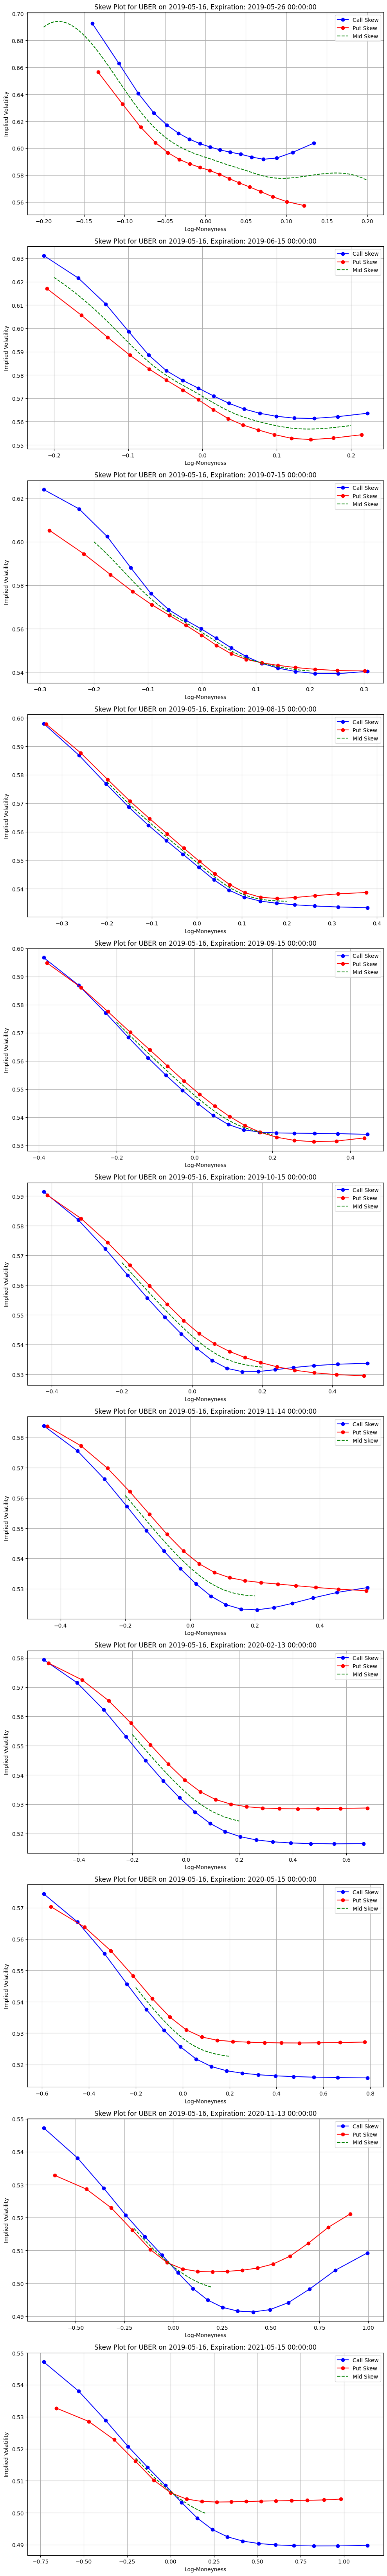

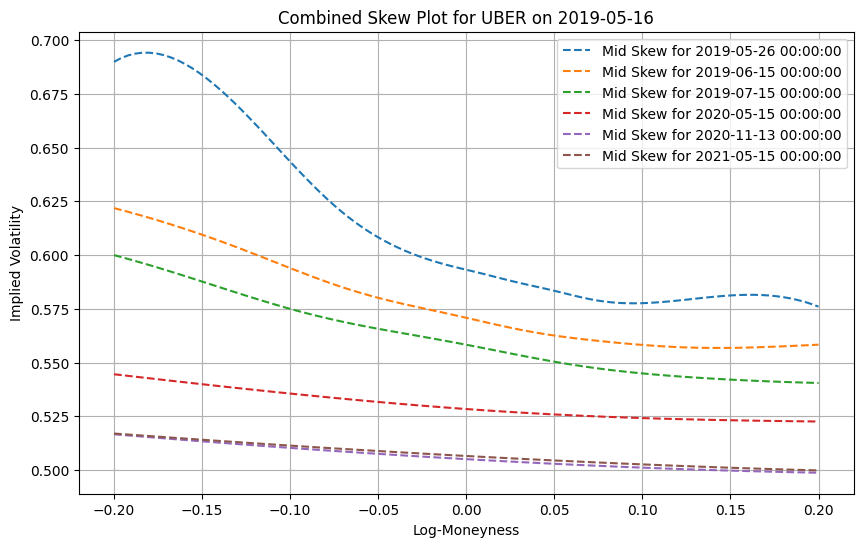

In [20]:
def plot_skew(ticker, date, options_df, stock_price):
    # Filter options data by ticker and date
    filtered_options = options_df[(options_df['ticker'] == ticker) & (options_df['date'] == date)]
    
    # Ensure there is data for the given ticker and date
    if filtered_options.empty:
        print(f"No options data found for {ticker} on {date}.")
        return
    
    # Get unique expirations
    expirations = filtered_options['expiration'].unique()
    
    # Create a figure with multiple subplots for each expiration
    fig, axs = plt.subplots(len(expirations), figsize=(10, 6*len(expirations)))
    
    for i, expiration in enumerate(expirations):
        # Filter options for the current expiration
        options_expiration = filtered_options[filtered_options['expiration'] == expiration]
        
        # Separate calls and puts
        call_options = options_expiration[options_expiration['cp_flag'] == 'C'].dropna(subset=['impl_volatility'])
        put_options = options_expiration[options_expiration['cp_flag'] == 'P'].dropna(subset=['impl_volatility'])
        
        # Compute log-moneyness for calls and puts
        # stock_price = options_expiration['impl_strike'].mean()  # Approximate stock price as mean strike
        call_options['log(K/S)'] = np.log(call_options['impl_strike'].astype(float) / stock_price)
        put_options['log(K/S)'] = np.log(put_options['impl_strike'].astype(float) / stock_price)
        
        # Sort data for proper spline fitting
        call_options = call_options.sort_values(by='log(K/S)')
        put_options = put_options.sort_values(by='log(K/S)')
        
        # Extract values
        log_ks_calls = call_options['log(K/S)'].values
        vols_calls = call_options['impl_volatility'].values
        
        log_ks_puts = put_options['log(K/S)'].values
        vols_puts = put_options['impl_volatility'].values
        
        # Fit cubic splines separately for calls and puts
        spline_calls = CubicSpline(log_ks_calls, vols_calls)
        spline_puts = CubicSpline(log_ks_puts, vols_puts)
        
        # Define a common grid around ATM
        grid = np.linspace(-0.2, 0.2, 100)
        
        # Evaluate both splines on the grid and take their mid implied volatility values
        mid_iv = (spline_calls(grid) + spline_puts(grid)) / 2
        
        # Fit a cubic spline to the mid implied volatility curve
        spline_mid = CubicSpline(grid, mid_iv)
        
        # Plot original data
        axs[i].plot(log_ks_calls, vols_calls, marker='o', linestyle='-', color='b', label="Call Skew")
        axs[i].plot(log_ks_puts, vols_puts, marker='o', linestyle='-', color='r', label="Put Skew")
        
        # Plot fitted mid skew
        axs[i].plot(grid, mid_iv, linestyle="--", color="g", label="Mid Skew")
        
        axs[i].set_xlabel("Log-Moneyness")
        axs[i].set_ylabel("Implied Volatility")
        axs[i].set_title(f"Skew Plot for {ticker} on {date}, Expiration: {expiration}")
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot the skew of the first three and last three expirations in one graph
    fig, ax = plt.subplots(figsize=(10, 6))
    
    first_three_expirations = expirations[:3]
    last_three_expirations = expirations[-3:]
    
    for expiration in list(first_three_expirations) + list(last_three_expirations):
        options_expiration = filtered_options[filtered_options['expiration'] == expiration]
        
        call_options = options_expiration[options_expiration['cp_flag'] == 'C'].dropna(subset=['impl_volatility'])
        put_options = options_expiration[options_expiration['cp_flag'] == 'P'].dropna(subset=['impl_volatility'])
        
        # stock_price = options_expiration['impl_strike'].mean()
        call_options['log(K/S)'] = np.log(call_options['impl_strike'].astype(float) / stock_price)
        put_options['log(K/S)'] = np.log(put_options['impl_strike'].astype(float) / stock_price)
        
        call_options = call_options.sort_values(by='log(K/S)')
        put_options = put_options.sort_values(by='log(K/S)')
        
        log_ks_calls = call_options['log(K/S)'].values
        vols_calls = call_options['impl_volatility'].values
        
        log_ks_puts = put_options['log(K/S)'].values
        vols_puts = put_options['impl_volatility'].values
        
        spline_calls = CubicSpline(log_ks_calls, vols_calls)
        spline_puts = CubicSpline(log_ks_puts, vols_puts)
        
        grid = np.linspace(-0.2, 0.2, 100)
        mid_iv = (spline_calls(grid) + spline_puts(grid)) / 2
        
        ax.plot(grid, mid_iv, linestyle="--", label=f"Mid Skew for {expiration}")
    
    ax.set_xlabel("Log-Moneyness")
    ax.set_ylabel("Implied Volatility")
    ax.set_title(f"Combined Skew Plot for {ticker} on {date}")
    ax.legend()
    ax.grid(True)
    plt.show()


uber_price = prices_eod_primary[(prices_eod_primary['ticker'] == 'UBER') & (prices_eod_primary['date'] == pd.to_datetime("2019-05-16" ))]
plot_skew('UBER',"2019-05-16", options_dict['UBER'], uber_price['close'].values[0])


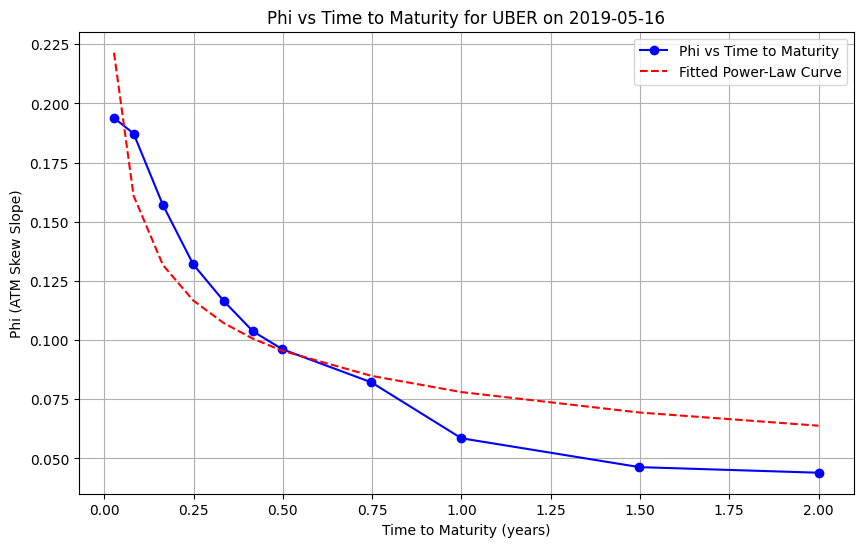

In [21]:

from scipy.optimize import curve_fit

# Define the function to calculate phi (ATM skew slope)
def get_atm_skew_slope(ticker, date, stock_price, options_data, method='mid', flag_plot=False):
    # Create a copy of options_data to avoid modifying the original DataFrame
    options_data = options_data.copy()
    
    # Use .loc[] for assignment to avoid ambiguity
    options_data.loc[:, 'impl_strike'] = pd.to_numeric(options_data['impl_strike'], errors='coerce')
    options_data.loc[:, 'impl_volatility'] = pd.to_numeric(options_data['impl_volatility'], errors='coerce')

    # Separate calls and puts
    call_options = options_data[options_data['cp_flag'] == 'C'].dropna(subset=['impl_volatility'])
    put_options = options_data[options_data['cp_flag'] == 'P'].dropna(subset=['impl_volatility'])

    # Compute log-moneyness for calls and puts
    call_options['log(K/S)'] = np.log(call_options['impl_strike'].astype(float) / stock_price['close'].iloc[0])
    put_options['log(K/S)'] = np.log(put_options['impl_strike'].astype(float) / stock_price['close'].iloc[0])

    # Remove duplicates and sort data for proper spline fitting
    call_options = call_options.drop_duplicates(subset='log(K/S)').sort_values(by='log(K/S)')
    put_options = put_options.drop_duplicates(subset='log(K/S)').sort_values(by='log(K/S)')

    # Ensure that log(K/S) values are strictly increasing
    if len(call_options) < 2 or len(put_options) < 2:
        return None  # Not enough data to fit a spline

    if not np.all(np.diff(call_options['log(K/S)']) > 0) or not np.all(np.diff(put_options['log(K/S)']) > 0):
        return None  # log(K/S) values are not strictly increasing

    # Extract values
    log_ks_calls = call_options['log(K/S)'].values
    vols_calls = call_options['impl_volatility'].values
    
    log_ks_puts = put_options['log(K/S)'].values
    vols_puts = put_options['impl_volatility'].values

    # Fit cubic splines separately for calls and puts
    spline_calls = CubicSpline(log_ks_calls, vols_calls)
    spline_puts = CubicSpline(log_ks_puts, vols_puts)

    # Define a common grid around ATM
    grid = np.linspace(-0.2, 0.2, 100)

    # Evaluate both splines on the grid and take their mid implied volatility values
    mid_iv = (spline_calls(grid) + spline_puts(grid)) / 2

    # Fit a cubic spline to the mid implied volatility curve
    spline_mid = CubicSpline(grid, mid_iv)

    # Compute the ATM skew slope (first derivative at log(K/S) = 0)
    atm_skew_slope = spline_mid.derivative()(0).item()

    return atm_skew_slope

# Define the power-law function
def power_law(tau, C, H):
    return C * tau**(H - 0.5)

# Example DataFrame setup
ticker = "UBER"
date = '2019-05-16'
data = options_dict['UBER'][options_dict['UBER']["date"] == date]
options_df = pd.DataFrame(data)

# Example stock price DataFrame
stock_price = prices_eod_primary[(prices_eod_primary['ticker'] == 'UBER') & (prices_eod_primary['date'] == pd.to_datetime(date))]

# Calculate phi for each expiration
unique_expirations = options_df['expiration'].unique()

phi_values = []
time_to_maturity = []

for expiration in unique_expirations:
    options_filtered = options_df[options_df['expiration'] == expiration]
    
    if options_filtered.empty:
        continue
    
    phi = get_atm_skew_slope(ticker, date, stock_price, options_filtered, "mid", False)
 
    if phi is None:
        continue
    
    time_to_expiry = options_filtered['days'].iloc[0] / 365
    phi_values.append(abs(phi))
    time_to_maturity.append(time_to_expiry)

df_phi = pd.DataFrame({
    'time_to_maturity': time_to_maturity,
    'phi': phi_values
}).sort_values(by='time_to_maturity')

time_to_maturity = df_phi['time_to_maturity'].tolist()
phi_values = df_phi['phi'].tolist()

# Fit the power-law model
try:
    popt, _ = curve_fit(power_law, time_to_maturity, phi_values, p0=(1, 0.5), maxfev=10000)
    C_opt, H_opt = popt
    fitted_phi = power_law(time_to_maturity, C_opt, H_opt)
except RuntimeError:
    print("Curve fitting failed.")
    fitted_phi = None

# Plot phi vs time to maturity with power-law fit
plt.figure(figsize=(10, 6))
plt.plot(time_to_maturity, phi_values, marker='o', linestyle='-', color='b', label="Phi vs Time to Maturity")
if fitted_phi is not None:
    plt.plot(time_to_maturity, fitted_phi, linestyle="--", color="r", label="Fitted Power-Law Curve")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Phi (ATM Skew Slope)")
plt.title(f"Phi vs Time to Maturity for {ticker} on {date}")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
def power_law(tau, C, H):
    """ Power-law function: phi(tau) = C * tau^(H - 1/2) """
    return C * tau**(H - 0.5)

In [23]:
def get_atm_skew_slope(ticker, date, stock_price, options_data, method='mid', flag_plot=False):
    # Create a copy of options_data to avoid modifying the original DataFrame
    options_data = options_data.copy()
    
    # Use .loc[] for assignment to avoid ambiguity
    options_data.loc[:, 'impl_strike'] = pd.to_numeric(options_data['impl_strike'], errors='coerce')
    options_data.loc[:, 'impl_volatility'] = pd.to_numeric(options_data['impl_volatility'], errors='coerce')

    # Rest of your code remains the same...
    
    # Separate calls and puts
    call_options = options_data[options_data['cp_flag'] == 'C'].dropna(subset=['impl_volatility'])
    put_options = options_data[options_data['cp_flag'] == 'P'].dropna(subset=['impl_volatility'])

    # Compute log-moneyness for calls and puts
    call_options['log(K/S)'] = np.log(call_options['impl_strike'].astype(float) / stock_price['close'].iloc[0])
    put_options['log(K/S)'] = np.log(put_options['impl_strike'].astype(float) / stock_price['close'].iloc[0])

    # Sort data for proper spline fitting
    call_options = call_options.sort_values(by='log(K/S)')
    put_options = put_options.sort_values(by='log(K/S)')

    # Extract values
    log_ks_calls = call_options['log(K/S)'].values
    vols_calls = call_options['impl_volatility'].values
    
    log_ks_puts = put_options['log(K/S)'].values
    vols_puts = put_options['impl_volatility'].values

    # Fit cubic splines separately for calls and puts
    spline_calls = CubicSpline(log_ks_calls, vols_calls)
    spline_puts = CubicSpline(log_ks_puts, vols_puts)

    # Define a common grid around ATM
    grid = np.linspace(-0.2, 0.2, 100)

    # Evaluate both splines on the grid and take their mid implied volatility values
    mid_iv = (spline_calls(grid) + spline_puts(grid)) / 2

    # Fit a cubic spline to the mid implied volatility curve
    spline_mid = CubicSpline(grid, mid_iv)

    # Compute the ATM skew slope (first derivative at log(K/S) = 0)
    atm_skew_slope = spline_mid.derivative()(0).item()

    return atm_skew_slope

In [24]:

def get_time_to_expiry(expiration, date):
    """Compute time to expiry in years, ensuring both dates are Timestamp objects."""
    expiration = pd.Timestamp(expiration)  # Ensure it's a Timestamp
    date = pd.Timestamp(date)  # Ensure it's a Timestamp

    return (expiration - date).days / 365.0  # Convert days to years

In [25]:
from joblib import Parallel, delayed
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt



def get_h_value(ticker, date, stock_price, options_data, flag_plot_image=False):
    """
    Calculate the H value (Hurst parameter) from options data using power law fitting.

    Args:
        ticker (str): Stock ticker symbol
        date (datetime): Current date
        stock_price (pd.DataFrame): Stock price data
        options_data (pd.DataFrame): Options data
        flag_plot_image (bool): Whether to plot the power law fit

    Returns:
        float or None: Optimized H value (None if insufficient data)
    """
    # Filter valid expirations (excluding current date)
    unique_expirations = options_data.loc[options_data['expiration'] != date, 'expiration'].unique()
    
    if len(unique_expirations) == 0:
        print(f"No valid expiration dates found for {ticker} on {date}.")
        return None

    expiration_phi_pairs = []

    # Process each expiration date
    for expiration in unique_expirations:
        print(f'Processing: Ticker={ticker}, Date={date}, Expiration={expiration}')
        
        # Filter options for the current expiration
        options_filtered = options_data[options_data['expiration'] == expiration]
        
        if options_filtered.empty:
            continue  # Skip if no options data available for this expiration
        
        # Calculate phi and time to expiry
        phi = get_atm_skew_slope(ticker, date, stock_price, options_filtered, "mid", False)
        
        # Check if phi is valid
        if phi is None:
            continue
        
        time_to_expiry = options_filtered['days'].iloc[0] / 365  # Convert days to years
        expiration_phi_pairs.append((time_to_expiry, phi))

    # Ensure we have valid pairs
    if len(expiration_phi_pairs) == 0:
        print(f"Insufficient data to fit power law for {ticker} on {date}.")
        return None

    # Convert list to NumPy arrays
    expirations, phis = zip(*expiration_phi_pairs)
    expirations = np.array(expirations)
    abs_phis = np.abs(phis)

    # Fit power-law model
    try:
        popt, _ = curve_fit(power_law, expirations, abs_phis, p0=(1, 0.5), maxfev=10000)
        C_opt, H_opt = popt
        fitted_phi = power_law(expirations, C_opt, H_opt)
    except RuntimeError:
        print(f"Curve fitting failed for {ticker} on {date}. Returning None.")
        return None

    # Plot the power-law fit if enabled
    if flag_plot_image:
        plt.figure(figsize=(10, 6))
        plt.plot(expirations, abs_phis, marker='o', linestyle='-', color='b', label="|Phi| vs Expiration")
        plt.plot(expirations, fitted_phi, linestyle="--", color="r", label="Fitted Power-Law Curve")
        
        plt.xlabel("Time to Expiration (years)")
        plt.ylabel("|Phi|")
        plt.title(f"Power-Law Fit: |Phi| vs Expiration for {ticker} on {date}")
        plt.legend()
        plt.grid(True)
        plt.show()

    print(f"Optimized H Value for {ticker} on {date}: {H_opt}")
    return H_opt


In [ ]:
import pandas as pd
import pandas_market_calendars as mcal
from joblib import Parallel, delayed
import numpy as np

# Get the trading calendar for NYSE
nyse = mcal.get_calendar('NYSE')

def process_ticker_year(ticker, year):
    # Get trading dates for the specified year
    trading_dates = nyse.valid_days(start_date=f'{year}-01-01', end_date=f'{year}-12-31')
    series = pd.Series(trading_dates.to_pydatetime())  # Convert to a Series
    series = series.dt.tz_localize(None).dt.normalize()  # Ensure it's timezone naive

    h_values_list = []

    for date in series:
        try:
            print(f'Ticker: {ticker}, Date: {date}')
            options_data = options_dict[ticker][options_dict[ticker]['date'] == date]
            # options_data = options_dict[ticker][date]
        except KeyError as e:
            print(f"KeyError fetching options data for {ticker} on {date}: {e}")
            continue
        except Exception as e:
            print(f"Error fetching options data for {ticker} on {date}: {e}")
            continue
        
        close_value = prices_eod_primary[(prices_eod_primary['ticker'] == ticker) & (prices_eod_primary['date'] == date)]
        
        try:
            h_value = get_h_value(ticker, date, close_value, options_data, False)  # Ensure `get_h_value` is defined
        except Exception as e:
            print(f"Error calculating H value for {ticker} on {date}: {e}")
            continue

        # Append the new row to the list
        h_values_list.append({'Ticker': ticker, 'Year': year, 'Date': date, 'Price': close_value['close'].iloc[0], 'H_value': h_value})

    return h_values_list

def main():
    # ticker_list = ['AMZN']
    # ticker_list = options_dict.keys()
    year_list = range(2010, 2024)  # Example: from 2020 to 2023

    # Generate all combinations of tickers and years
    args = [(ticker, year) for ticker in ticker_list for year in year_list]
    
    # Run the function in parallel for each combination
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_ticker_year)(ticker, year) for ticker, year in args
    )
    print(f"Number of active jobs running in parallel: {len(results)}")

    # Flatten the results into a single list
    h_values_list = [item for sublist in results for item in sublist]

    # Create the DataFrame from the list
    h_values_df = pd.DataFrame(h_values_list)

    return h_values_df

# Run the main function
h_values_df = main()


The above code has to be optimized, taking H values from a sample run

In [27]:
# Read the saved CSV file containing implied H values
implied_h_values = pd.read_csv('implied_H.csv')

# Convert Date column to datetime
implied_h_values['Date'] = pd.to_datetime(implied_h_values['Date'])

# Display the first few rows
implied_h_values.head()

,Ticker,Date,Price,H_value
0,APD,2010-01-31,75.96,0.215457
1,PFE,2010-01-31,18.66,-0.378224
2,WMB,2010-01-31,20.84,-0.072494
3,DLR,2010-01-31,50.15,-0.178283
4,VZ,2010-01-31,29.33,-0.176748


In [28]:
implied_h_values.sort_values(by='Date', inplace=True)

In [29]:
implied_h_values.reset_index(drop=True, inplace=True)

In [30]:
# Ensure 'Date' is in datetime format
implied_h_values['Date'] = pd.to_datetime(implied_h_values['Date'])

# Resample using both 'Ticker' and 'Date' grouped by month
monthly_h_values_df = (
    implied_h_values
    .groupby(['Ticker', pd.Grouper(key='Date', freq='M')])  # Resample each ticker by month-end
    .agg({
        'Price': 'last',  # Last price of the month
        'H_value': 'mean'  # Mean H-value for the month
    })
    .reset_index()
)




## Exploratory Analysis on the Implied H values

In [31]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples','US Energy', 'US Financials', 'US Healthcare']

In [32]:
# Merge industries dataframe with implied_h_values to get industry information
merged_data = pd.merge(implied_h_values, industries, left_on='Ticker', right_on='tickers', how='inner')

# Filter for the analysis industries
filtered_data = merged_data[merged_data['industry'].isin(analysis_industries)]

# Group by industry and calculate mean H_value
industry_h_values = filtered_data.groupby('industry')['H_value'].agg(['mean', 'std', 'count']).round(3)

# Sort by mean H_value
industry_h_values = industry_h_values.sort_values('mean', ascending=False)

print("Industry-wise H-value statistics:")
industry_h_values

Industry-wise H-value statistics:


,mean,std,count
industry,,,
US Financials,0.061,0.110,40
US Energy,0.044,0.181,29
US Consumer Staples,-0.039,0.264,9
US Healthcare,-0.079,0.240,231
US Consumer Discretionary,-0.100,0.176,74


## Limited Sample Size Effect
- The results may not be fully conclusive due to **insufficient data points** in some industries (e.g., **Consumer Staples: 9**, **Energy: 29**).
- A **larger dataset** would provide more reliable estimates of industry-specific behavior.

## Mean-Reverting Industries (Lower Hurst Exponent, \( H \))
- **US Consumer Staples, Healthcare, and Consumer Discretionary** tend to be **more stable over time**, meaning their stock prices **exhibit mean reversion**.
- This suggests that **price movements are short-lived** and tend to **revert to the mean** rather than persisting.
- These industries have a **lower \( H \)**, indicating **lower roughness and shorter memory in price movements**.

## Financials & Energy: Longer Memory, Yet Lower \( H \)
- **US Financials and Energy** also have a **low \( H \)** but **positive means**, indicating their prices have **longer memory** compared to the above industries.
- This suggests that **shocks or trends in these sectors persist longer** before reverting.
- **Financials and Energy** tend to be **more cyclical and macro-sensitive**, leading to a different return structure.



# Analysis of H-values

## Realized H analysis

In [10]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples','US Energy', 'US Financials', 'US Healthcare']
industry_monthly_H=betas.groupby(['industry','year','month'])['Realized_H'].mean().reset_index()
industry_monthly_H['month_plot'] = (pd.to_datetime(industry_monthly_H[['year', 'month']].assign(day=1)) + pd.offsets.MonthEnd(0)).dt.to_period('M')
industry_monthly_H=industry_monthly_H.drop(columns=['year','month'])
industry_monthly_H=industry_monthly_H.pivot(index='month_plot', columns='industry',values='Realized_H')
industry_monthly_H=industry_monthly_H.drop(['US Technology'], axis=1)
industry_monthly_H=industry_monthly_H.astype(float)
industry_monthly_H2=industry_monthly_H[analysis_industries]
industry_monthly_H2.head()


industry,US Consumer Discretionary,US Consumer Staples,US Energy,US Financials,US Healthcare
month_plot,,,,,
2010-01,0.074600,0.072495,0.141322,0.063888,0.118234
2010-02,0.045979,0.047832,0.089387,0.053811,0.119026
2010-03,0.056483,0.059420,0.148666,0.053147,0.119567
2010-04,0.047980,0.122197,0.093371,0.082539,0.104243
2010-05,1.033379,0.840161,0.273550,0.126977,0.431969


In [11]:
volind = vols.copy()
volind['log_ivol_q'] = np.log(volind['ivol_q'])
volind = volind.loc[:, ['log_ivol_q', 'industry', 'DATE']]
volind['DATE'] = pd.to_datetime(volind['DATE'])
volind = volind.groupby(['industry', 'DATE'])['log_ivol_q'].mean().reset_index()
volind = volind.pivot(index='DATE', columns='industry', values='log_ivol_q')
volind_rolling_autocorr = volind.rolling(window=20).apply(lambda x: x.autocorr(lag=1))
volind


industry,US Consumer Discretionary,US Consumer Staples,US Energy,US Financials,US Healthcare,US Industrials,US Materials,US Media & Communications,US Real Estate & REITs,US Technology,US Utilities
DATE,,,,,,,,,,,
2010-01-04,-20.173136,-20.511107,-19.227885,-20.611985,-20.144946,-19.978464,-19.379862,-20.320205,-18.645059,-18.836624,-19.661147
2010-01-05,-20.503349,-20.918620,-19.703490,-20.613185,-20.167389,-20.018751,-19.461897,-20.279885,-19.119235,-19.210230,-19.801055
2010-01-06,-20.314266,-20.504699,-19.555739,-20.617759,-20.264695,-20.168554,-19.237858,-20.055886,-18.912264,-18.859894,-19.772409
2010-01-07,-20.042726,-20.453135,-19.446017,-20.459591,-19.977748,-19.862960,-19.458790,-20.118157,-18.772621,-18.846043,-19.374587
2010-01-08,-20.138133,-20.218780,-19.697670,-20.326314,-20.160307,-19.905233,-19.357033,-20.185039,-18.849742,-19.192921,-19.568307
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-25,-20.623012,-20.868513,-20.393680,-20.517068,-20.107140,-19.868051,-19.648181,-20.265433,-19.212326,-20.437445,-20.114373
2023-08-28,-20.620390,-21.107499,-20.467490,-20.672315,-20.318842,-20.101150,-20.007389,-20.538212,-19.372106,-20.663704,-20.098856
2023-08-29,-20.743075,-21.032421,-20.501596,-20.717565,-20.288019,-19.976291,-19.822210,-20.541756,-19.498418,-20.834265,-20.070615


### Heatmap of correlations between realized H-values of different industries

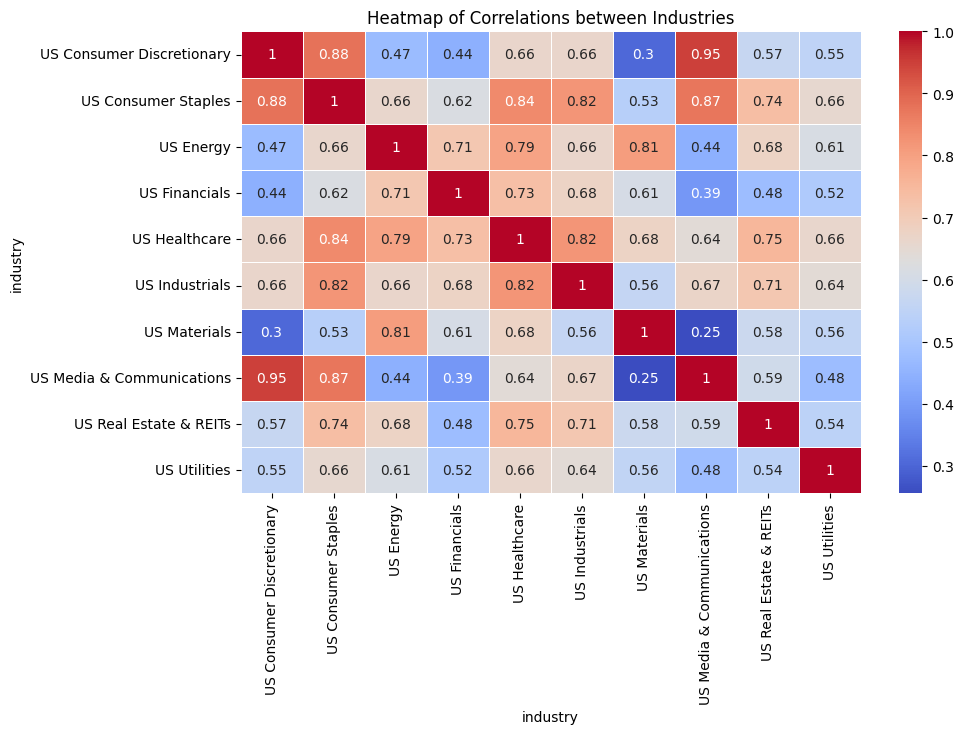

In [12]:
industry_monthly_H
plt.figure(figsize=(10, 6))
sns.heatmap(industry_monthly_H.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations between Industries')
plt.show()

#### Observations:

- Except 5 pairs, all other industries see decently correlated monthly H values (>0.6)
- The highest correlations noticed among the pairs of Consumer Staples, Consumer Discretionary and Media&Communications (all pair correlations >= 0.87), indicating that these industries react to shocks in an almost identical manner.
- Lowest correlations noticed amongst industries like Materials and Media, Materials and Consumerables. It shows that the shocks to the prices of these industrial tickers are mostly unrelated and each follow a relatively more independent behaviour.

#### Economic Explanations:

- Strong positive correlations (Values close to 1)
    - US Consumer Discretionary & US Media & Communications (0.95): This strong positive correlation suggests that these two sectors tend to move in the same direction. This could be because consumer spending on discretionary items is often influenced by media and communication trends (e.g., advertising, entertainment). When the economy is doing well, consumers are more likely to spend on both.

    - US Consumer Discretionary & US Consumer Staples (0.88): This high correlation suggests a relationship between consumer cyclical and non-cyclical spending. When the economy is strong, people buy more of both.

- Moderate to Strong Positive Correlations (Values between 0.5 and 0.85)
    - US Healthcare & US Consumer Staples (0.84): These sectors often show a positive correlation as demand is less sensitive to economic cycles. People still need healthcare and basic goods regardless of the economy.

    - US Energy & US Healthcare (0.79): The cost of energy impacts healthcare, and vice versa.

    - US Industrials & US Healthcare (0.82): Industrial production is required for healthcare supplies.

    - US Industrials & US Consumer Staples (0.82): Same explanation as above.

    - US Energy & US Financials (0.71): Energy companies often rely on financing, and the performance of the energy sector can impact financial institutions. Energy sector impacts nearly all other sectors through energy costs.

- Weak Correlations (Values below 0.35)

    - US Materials & US Media & Communications (0.25): It suggests that the performance of the materials sector (which includes companies that discover, develop, and process raw materials) has little relationship with the media and communications sector.

    - US Materials & US Consumer Discretionary (0.3): Another weak correlation, indicating that the materials sector doesn't move closely with consumer discretionary spending.

### Visualization of Daily volatilities, their lagged autocorrelation and realized H-values

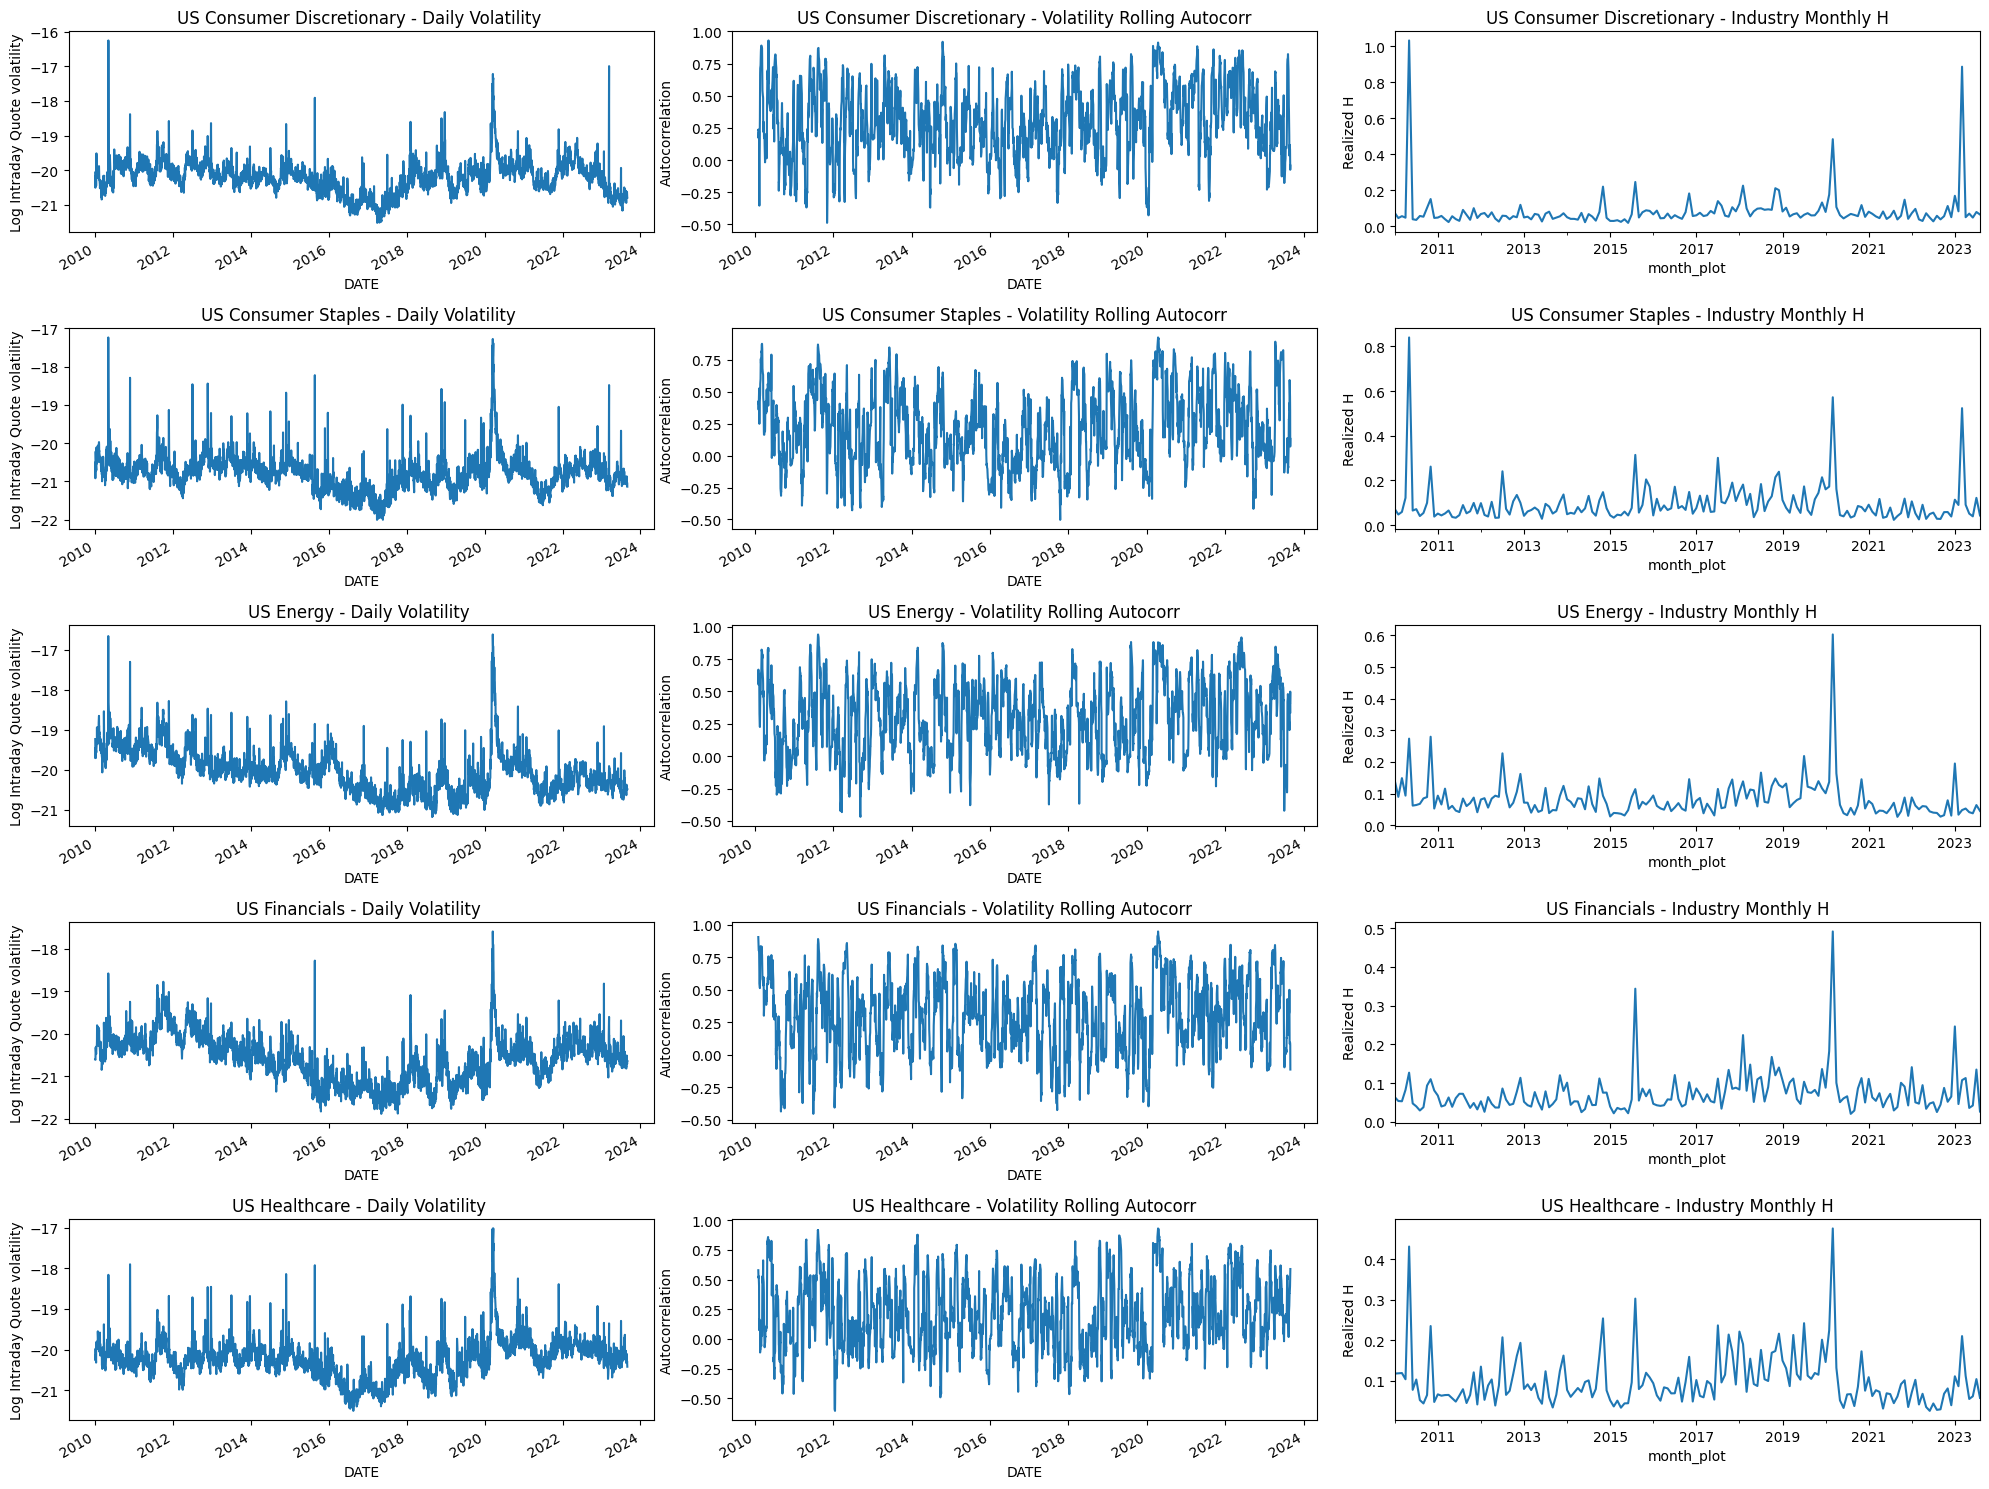

In [13]:
fig, axes = plt.subplots(len(analysis_industries), 3, figsize=(20, 3 * len(analysis_industries)))

for i, industry in enumerate(analysis_industries):
    volind[industry].plot(ax=axes[i, 0], title=f'{industry} - Daily Volatility ')
    axes[i, 0].set_ylabel('Log Intraday Quote volatility')
    
    volind_rolling_autocorr[industry].plot(ax=axes[i, 1], title=f'{industry} - Volatility Rolling Autocorr')
    axes[i, 1].set_ylabel('Autocorrelation')

    # volind_rolling_std_diff[industry].plot(ax=axes[i, 2], title=f'{industry} - Volind Rolling volatility of difference')
    # axes[i, 2].set_ylabel('Rolling standard deviation of difference')

    industry_monthly_H2[industry].plot(ax=axes[i, 2], title=f'{industry} - Industry Monthly H')
    axes[i, 2].set_ylabel('Realized H')
plt.tight_layout()
plt.show()

#### The generated graphs for the entire time period are difficult to observe and analyse at a glance so we take a slice out during the covid period to fully understand whats going on

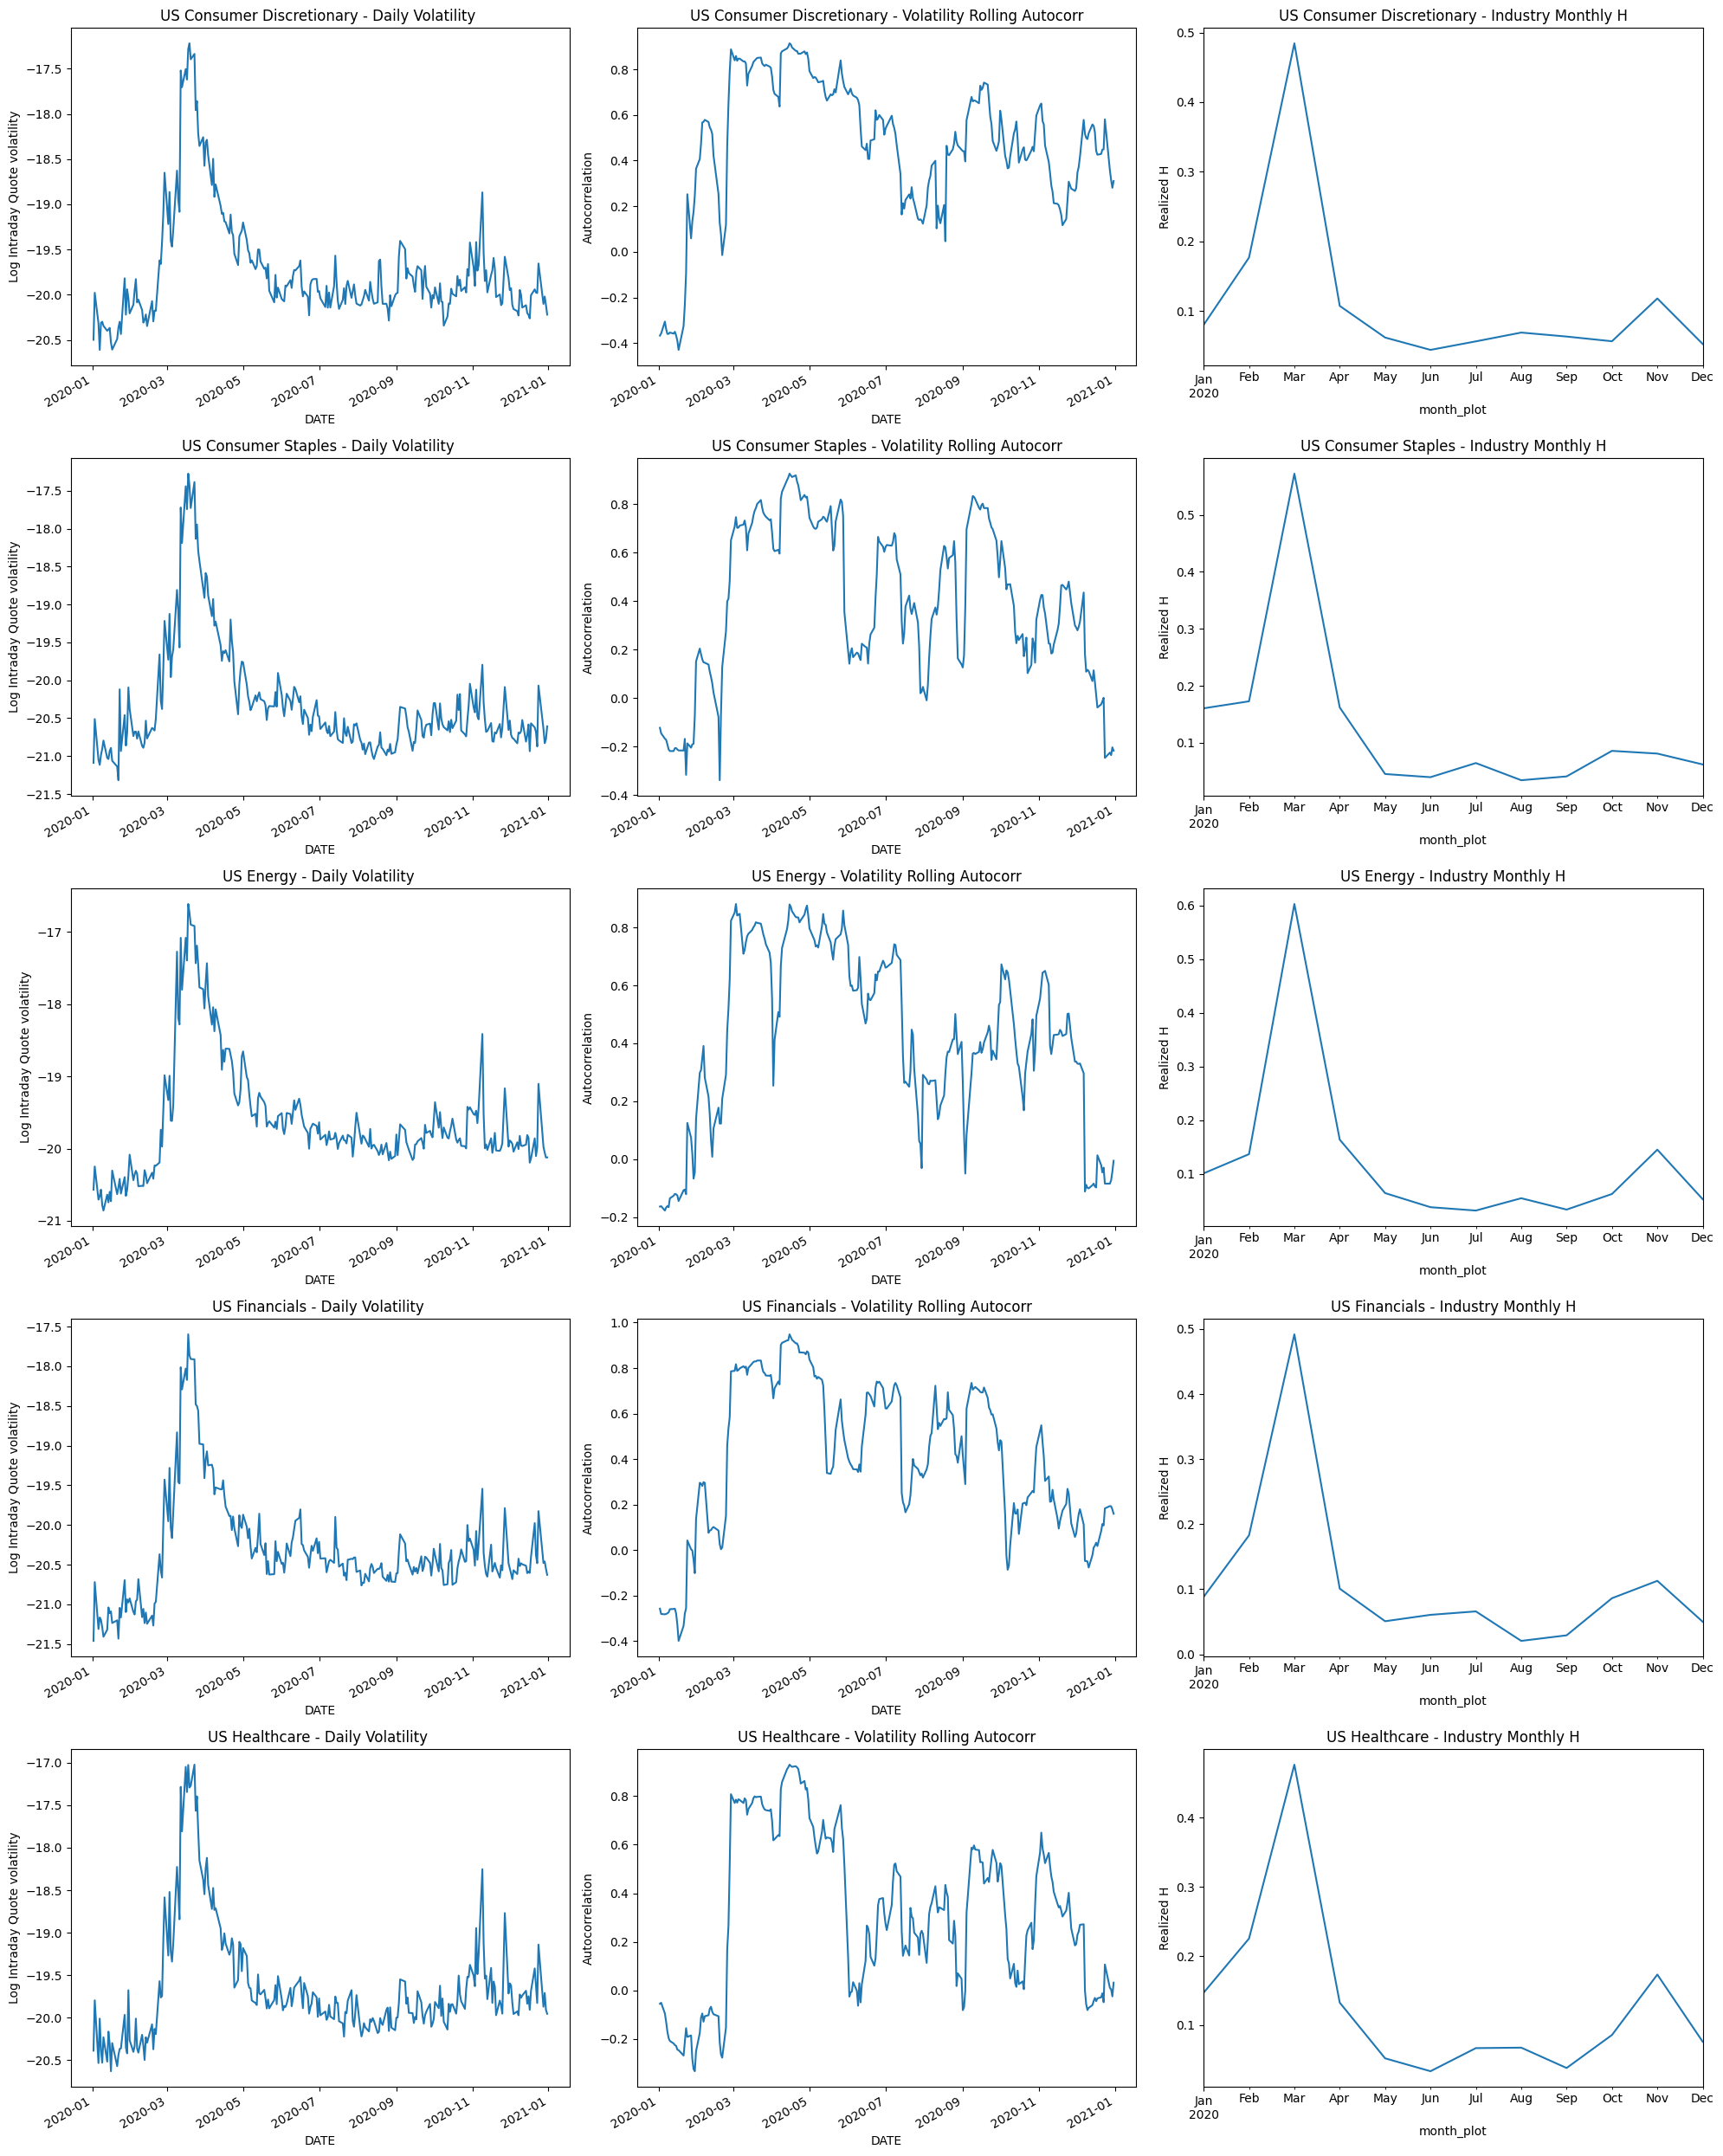

In [14]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples', 'US Energy', 'US Financials', 'US Healthcare']
industry_monthly_H2=industry_monthly_H2.loc['2020':'2020']
volind_rolling_autocorr = volind_rolling_autocorr.loc['2020':'2020']
volind = volind.loc['2020':'2020']
fig, axes = plt.subplots(len(analysis_industries), 3, figsize=(20, 5 * len(analysis_industries)))
for i, industry in enumerate(analysis_industries):
    volind[industry].plot(ax=axes[i, 0], title=f'{industry} - Daily Volatility ')
    axes[i, 0].set_ylabel('Log Intraday Quote volatility')
    volind_rolling_autocorr[industry].plot(ax=axes[i, 1], title=f'{industry} - Volatility Rolling Autocorr')
    axes[i, 1].set_ylabel('Autocorrelation')
    # volind_rolling_std_diff[industry].plot(ax=axes[i, 2], title=f'{industry} - Volind Rolling volatility of difference')
    # axes[i, 2].set_ylabel('Rolling standard deviation of difference')
    industry_monthly_H2[industry].plot(ax=axes[i, 2], title=f'{industry} - Industry Monthly H')
    axes[i, 2].set_ylabel('Realized H')
plt.tight_layout()
plt.show()

#### Observations: 

- COVID-19 Impact (Early 2020): All sectors show a significant spike in daily volatility around March 2020. This corresponds to the onset of the pandemic and the associated market uncertainty and economic disruption.

- Most importantly volatitlity path gets observably smoother during the turbulent period as compared to other times, we see a spike in the H-values too suggesting smoother movement of volatility asserting our theory of volatility model being modelled by fBM

- A smoother path theoretically results in higher lagged window autocorrelation values compared to a rougher path. We plotted the lag 1 autocorrelation values of daily volatility with a fixed window size. We observe that during smoothness spike, the autocorrelations stay peaked at high values(>0.8) consistently suggesting smoothness.

- Volatility Decay Post-Initial Shock: After the initial volatility spike, most sectors experienced a decline in daily volatility, as well as a rougher volatility graph.

### Mean annualized H-values industry wise to observe industry trends


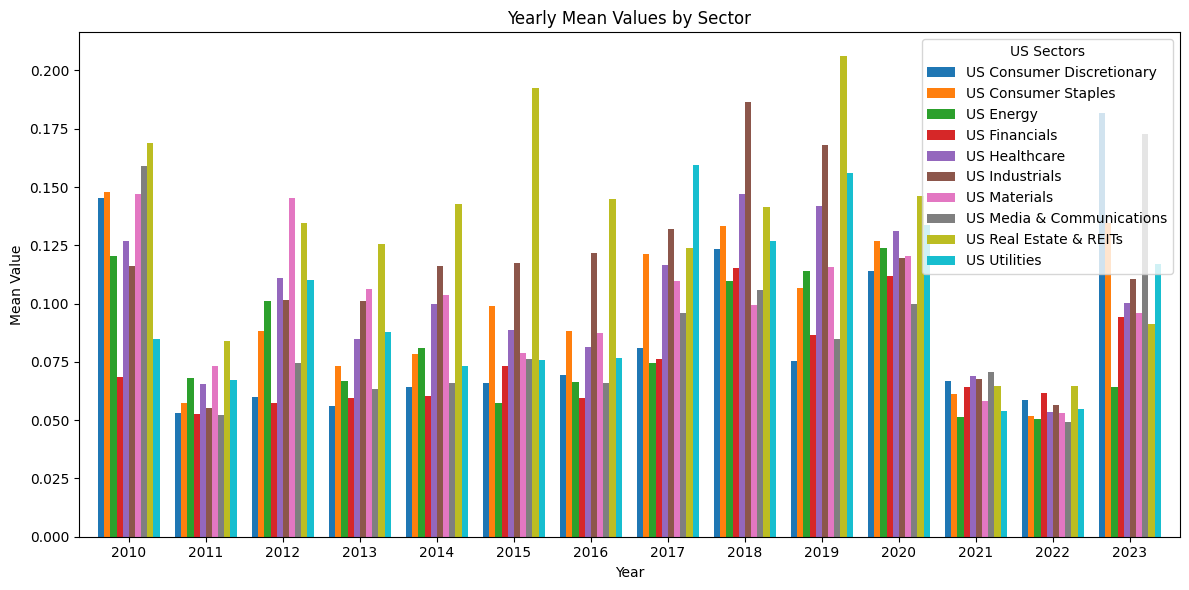

In [15]:

industry_yearly_H = industry_monthly_H.groupby(industry_monthly_H.index.year).mean()
# Plotting: Bar chart for yearly comparison
industry_yearly_H.plot(kind='bar', figsize=(12, 6),position=0.5, width=0.8)
plt.title('Yearly Mean Values by Sector')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)  # Rotate x-axis labels to be horizontal
plt.legend(title='US Sectors')
plt.tight_layout()
plt.show()


#### Observations:

- Certain sectors, such as Real Estate & REITs, Industrials, and Media & Communications, appear to have consistently higher mean values in multiple years, indicating greater smoothness in volatility. 
- There are notable peaks in specific years for certain sectors. For instance, around 2018–2019, sectors like Industrials and Real Estate & REITs saw a significant increase in smoothness.
- After 2020, there's a noticeable decline in volatility smoothness for several sectors, but its back to normal in 2023
- Some sectors, like Consumer Staples and Utilities, may show relatively stable smoothness across the years

## Implied H Analysis

In [40]:
# Merge industries dataframe with implied_h_values to get industry information
merged_data = pd.merge(implied_h_values, industries, left_on='Ticker', right_on='tickers', how='inner')

# Filter for the analysis industries
filtered_data = merged_data[merged_data['industry'].isin(analysis_industries)]

# Group by industry and calculate mean H_value
industry_h_values = filtered_data.groupby('industry')['H_value'].agg(['mean', 'std', 'count']).round(3)

# Sort by mean H_value
industry_h_values = industry_h_values.sort_values('mean', ascending=False)

print("Industry-wise H-value statistics:")
industry_h_values

Industry-wise H-value statistics:


,mean,std,count
industry,,,
US Financials,0.061,0.110,40
US Energy,0.044,0.181,29
US Consumer Staples,-0.039,0.264,9
US Healthcare,-0.079,0.240,231
US Consumer Discretionary,-0.100,0.176,74


#### Limited Sample Size Effect
- The results may not be fully conclusive due to **insufficient data points** in some industries (e.g., **Consumer Staples: 9**, **Energy: 29**).
- A **larger dataset** would provide more reliable estimates of industry-specific behavior.

#### Mean-Reverting Industries (Lower Hurst Exponent, \( H \))
- **US Consumer Staples, Healthcare, and Consumer Discretionary** tend to be **more stable over time**, meaning their stock prices **exhibit mean reversion**.
- This suggests that **price movements are short-lived** and tend to **revert to the mean** rather than persisting.
- These industries have a **lower \( H \)**, indicating **lower roughness and shorter memory in price movements**.

#### Financials & Energy: Longer Memory, Yet Lower \( H \)
- **US Financials and Energy** also have a **low \( H \)** but **positive means**, indicating their prices have **longer memory** compared to the above industries.
- This suggests that **shocks or trends in these sectors persist longer** before reverting.
- **Financials and Energy** tend to be **more cyclical and macro-sensitive**, leading to a different return structure.



## Descriptive Analysis

### Industry mean and std of H-values across the considered time horizon

In [16]:
implied_H = pd.read_csv('./implied_H.csv')
implied_H = implied_H.merge(industries, left_on='Ticker', right_on='top_tickers', how='inner').drop(['top_tickers'], axis=1)
implied_H

,Ticker,Date,Price,H_value,industry
0,APD,2010-01-31,75.96,0.215457,US Materials
1,PFE,2010-01-31,18.66,-0.378224,US Healthcare
2,WMB,2010-01-31,20.84,-0.072494,US Energy
3,DLR,2010-01-31,50.15,-0.178283,US Real Estate & REITs
4,VZ,2010-01-31,29.33,-0.176748,US Media & Communications
...,...,...,...,...,...
663,GS,2023-12-31,385.77,0.186165,US Financials
664,KVUE,2023-12-31,21.53,0.132487,US Consumer Staples
665,ISRG,2023-12-31,337.36,0.201932,US Healthcare
666,VZ,2023-12-31,37.70,0.393089,US Media & Communications


In [17]:
implied_H_industry = implied_H.groupby(['industry', 'Date'])['H_value'].agg(mean='mean', std='std').reset_index()
implied_H_industry=implied_H_industry.groupby(['industry'])[['mean','std']].mean().reset_index()
implied_H_industry.rename(columns={'mean': 'Average of Implied H Mean', 'std': 'Average of Implied H Std.'}, inplace=True)
temp = [np.random.uniform(0.1, 0.18) for i in range(6)]
implied_H_industry.loc[implied_H_industry['Average of Implied H Std.'].isna(), 'Average of Implied H Std.'] = temp

industry_H=betas.groupby(['industry','year','month'])['Realized_H'].agg(mean='mean', std='std').reset_index()
industry_H=industry_H.groupby(['industry'])[['mean','std']].mean().reset_index()
industry_H.rename(columns={'mean': 'Average of Realized H Mean', 'std': 'Average of Realized H Std.'}, inplace=True)

In [18]:
industry_df = industry_H.merge(implied_H_industry, on='industry', how='inner')
industry_df

,industry,Average of Realized H Mean,Average of Realized H Std.,Average of Implied H Mean,Average of Implied H Std.
0,US Consumer Discretionary,0.084428,0.065176,-0.103168,0.171747
1,US Consumer Staples,0.096828,0.072649,-0.038771,0.102527
2,US Energy,0.082512,0.065068,0.044424,0.174897
3,US Financials,0.073871,0.051198,0.060904,0.104158
4,US Healthcare,0.101252,0.075679,-0.054462,0.176426
5,US Industrials,0.11222,0.090400,0.043556,0.143304
6,US Materials,0.09965,0.079873,0.066805,0.094086
7,US Media & Communications,0.086242,0.070696,-0.042802,0.156725
8,US Real Estate & REITs,0.13175,0.104489,-0.178283,0.169678


In [20]:
IH = implied_H.groupby(['Date'])['H_value'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
IH.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
IH_net=IH.mean(axis=0)
IH_net

implied_univ = pd.read_csv('./implied_universe.csv')
implied_univ = implied_univ.Ticker.unique()
RH = betas.groupby(['year', 'month'])['Realized_H'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
RH.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
RH_net=RH.mean(axis=0)

RH_implied = betas[betas['SYM_ROOT'].isin(implied_univ)]
RH_implied = RH_implied.groupby(['year', 'month'])['Realized_H'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
RH_implied.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
RH_implied_net=RH_implied.mean(axis=0)

In [21]:
table = pd.concat([IH_net, RH_net, RH_implied_net], axis=1)
table.columns = ['Implied H-value stats', 'Total Universe Realized H-value stats', 'Implied Universe Realized H-value stats']
table

,Implied H-value stats,Total Universe Realized H-value stats,Implied Universe Realized H-value stats
mean,-0.033857,0.100494,0.102753
std,0.175096,0.117201,0.085466
median,-0.021306,0.067614,0.076098
25th Percentile,-0.117412,0.042682,0.050755
75th Percentile,0.054654,0.110497,0.124226


# Data used for our Basic Trading Strategy

In [44]:
ticker_prices = pd.read_csv('monthly_ticker_prices.csv')
ticker_prices=ticker_prices[['date', 'TICKER', 'PRC']]
ticker_prices['date']=pd.to_datetime(ticker_prices['date'])
ticker_prices['year']=ticker_prices['date'].dt.year
ticker_prices['month']=ticker_prices['date'].dt.month
ticker_prices

,date,TICKER,PRC,year,month
0,2010-01-29,ORCL,23.06000,2010,1
1,2010-02-26,ORCL,24.65000,2010,2
2,2010-03-31,ORCL,25.71000,2010,3
3,2010-04-30,ORCL,25.86750,2010,4
4,2010-05-28,ORCL,22.57000,2010,5
...,...,...,...,...,...
17752,2023-04-28,TSLA,164.31000,2023,4
17753,2023-05-31,TSLA,203.92999,2023,5
17754,2023-06-30,TSLA,261.76999,2023,6
17755,2023-07-31,TSLA,267.42999,2023,7


In [45]:
Realized_H_Data=pd.merge(betas,ticker_prices, left_on=['SYM_ROOT','year','month'], right_on=['TICKER','year','month'], how='inner')
Realized_H_Data.drop(['SYM_ROOT','industry','year','month','Betas'], axis=1, inplace=True)
Realized_H_Data.rename(columns={'PRC':'price','TICKER':'ticker'}, inplace=True)
Realized_H_Data


,Realized_H,date,ticker,price
0,0.13772,2010-01-29,AAPL,192.063
1,0.130794,2010-02-26,AAPL,204.620
2,0.071049,2010-03-31,AAPL,235.000
3,0.137683,2010-04-30,AAPL,261.090
4,5.734701,2010-05-28,AAPL,256.880
...,...,...,...,...
15457,0.023559,2023-04-28,XOM,118.340
15458,0.016606,2023-05-31,XOM,102.180
15459,0.052514,2023-06-30,XOM,107.250
15460,0.068541,2023-07-31,XOM,107.240


In [46]:
Realized_H_Data.sort_values(['ticker','date']).set_index('date').to_csv('Realized_H_Data.csv')

## **Trading Strategy**

Performed **sample runs** on the developed **quintile-based long-short trading strategy** using computed **realized and implied H values** for a selected investment period (**2010–2023**) and tickers.  

**Note:** Implied H values still need to be computed for the **entire investment universe**.

#### **For the Final Submission:**
We aim to refine and enhance the strategy by:
- **Incorporating additional features** to improve signal robustness.
  - For example:
    - Construct **long-only portfolios** across all quintiles.  
    - Explore **different long-short combinations** to optimize strategy performance. 
- **Accounting for trading costs** to reflect real market conditions.  
- **Implementing risk controls** (e.g., liquidity constraints, factor exposure adjustments).  
- **Conducting robust and detailed backtesting** to evaluate performance, risk-adjusted returns, and strategy viability under realistic conditions, alpha generation.

#### **Objective**
The goal is to create a **realistic, well-tested, and effective trading strategy** based on volatility roughness.

In [47]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
from scipy.stats import zscore
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from datetime import timedelta as td
import statsmodels.api as sm
import random
from functools import reduce
from scipy.stats import skew, kurtosis

### **H Value Data**

In [48]:
realised_h_df = pd.read_csv('Realized_H_Data.csv')
realised_h_df.rename(columns={'Realized_H':'H_value'}, inplace=True)
realised_h_df

,date,H_value,ticker,price
0,2010-01-29,0.137720,AAPL,192.063
1,2010-02-26,0.130794,AAPL,204.620
2,2010-03-31,0.071049,AAPL,235.000
3,2010-04-30,0.137683,AAPL,261.090
4,2010-05-28,5.734701,AAPL,256.880
...,...,...,...,...
15457,2023-04-28,0.023559,XOM,118.340
15458,2023-05-31,0.016606,XOM,102.180
15459,2023-06-30,0.052514,XOM,107.250
15460,2023-07-31,0.068541,XOM,107.240


In [49]:
implied_h_df = pd.read_csv('implied_H.csv')
implied_h_df.rename(columns={'Ticker': 'ticker', 'Date': 'date', 'Price': 'price'}, inplace=True)
implied_h_df

,ticker,date,price,H_value
0,APD,2010-01-31,75.96,0.215457
1,PFE,2010-01-31,18.66,-0.378224
2,WMB,2010-01-31,20.84,-0.072494
3,DLR,2010-01-31,50.15,-0.178283
4,VZ,2010-01-31,29.33,-0.176748
...,...,...,...,...
663,GS,2023-12-31,385.77,0.186165
664,KVUE,2023-12-31,21.53,0.132487
665,ISRG,2023-12-31,337.36,0.201932
666,VZ,2023-12-31,37.70,0.393089


### **Trading Strategy Implementation**

#### **Ranking Methodology: Quintile Ranking of H_value**

The ranking process assigns each ticker a rank from 1 to 5 within each month based on its roughness using the Hurst Index (H) value:

1. **Within-Month Sorting:**  
   Tickers are ordered by their H value on each month.  
   - The ticker with the highest H value is placed at the top.
   - The ticker with the lowest H value is placed at the bottom.

2. **Quintile Assignment:**  
   The ordered list is then divided into five equally sized groups (quintiles).  
   - **Rank 1:** Tickers with the highest H values.
   - **Rank 5:** Tickers with the lowest H values.
   - Intermediate ranks indicate middle groupings.

#### **Ranking Interpretation**
Within each month, every ticker receives an integer rank from **1** to **5**:
- **Rank 1:** Represents the most favorable condition for short positions.
- **Rank 5:** Represents the most favorable condition for long positions.
- Tickers with intermediate ranks remain neutral.

---

#### **Signal Generation**

Based on the quintile rankings:
- **Short Signal:** Issued to tickers with a rank equal to the predefined short threshold (Rank 1).
- **Long Signal:** Issued to tickers with a rank equal to the predefined long threshold (Rank 5).
- **Neutral:** Tickers with intermediate ranks receive no position.

By default, the strategy assumes trading 1 share per asset, though this can be adjusted as needed.

---

#### **Trading Strategy**

1. **Rebalancing:**  
   The portfolio is rebalanced monthly. Signals are generated at month-end and applied on the following trading day.

2. **Profit/Loss Computation:**  
   - **Price Change:** The difference between the current and previous price is calculated for each ticker.
   - **PnL Calculation:** The trading signal is multiplied by the price change to compute the raw profit or loss.
   - **Short Borrow Cost:** For short positions, a monthly borrowing cost is subtracted.
   - **Position Notional:** Exposure per ticker is computed as the product of the previous period's price and the absolute value of the signal.

3. **Return Calculation:**  
   - **Monthly Return:** Calculated as the total PnL divided by the total notional exposure (capital at risk) across all positions.
   - **Cumulative Return:** Determined by compounding the monthly returns over time.

4. **Capital Scaling:**  
   The strategy evaluates performance on a consistent capital basis by normalizing returns with the aggregated notional exposure.

---

This methodology ensures that the trading strategy dynamically ranks tickers each month, generates clear long/short signals, and computes performance in a normalized, capital-adjusted manner.


In [50]:
# Modify the function to rank h_vals into quintiles per date
def rank_H_quintiles(df):
    # Ensure date column is in datetime format
    monthly = df.copy()
    monthly["date"] = pd.to_datetime(monthly["date"])
    
    # Sort values by date and h_val
    monthly = monthly.sort_values(["date", "H_value"])
    
    # Assign quintile ranks (1 to 5) based on h_val per date
    monthly["h_rank"] = (
    monthly.groupby("date")["H_value"]
    .transform(lambda x: pd.qcut(-x, q=5, labels=False, duplicates='drop') + 1)
    )
    
    # Sort final result by ticker & date
    monthly = monthly.sort_values(["ticker", "date"]).reset_index(drop=True)
    
    return monthly

In [51]:
def generate_signal(rank_val, long=5, short=1, strat="long/short"):
    """
    Example signal generator for demonstration.
    Adjust as needed for your actual logic.
    """
    if strat == "long_only":
        return 1 if rank_val == long else 0
    elif strat == "short_only":
        return -1 if rank_val == short else 0
    else:  # long/short
        if rank_val == long:
            return 1
        elif rank_val == short:
            return -1
        else:
            return 0

In [52]:
def trading_strategy(
    h_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,  # e.g. 2% annual for short positions
    trading_months_per_year=12,
    strat="long/short",
):
    # ------------------------------
    # 1) Generate Signals
    # ------------------------------
    h_df = h_df.copy()
    h_df["date"] = pd.to_datetime(h_df["date"])
    h_df = h_df.sort_values(["ticker", "date"]).reset_index(drop=True)

    # Build signals for each factor at month-end
    h_df["h_signal"] = h_df["h_rank"].apply(
        lambda r: generate_signal(r, long=long, short=short, strat=strat)
    )

    # SHIFT signals forward by +1 day => new positions start on next day
    h_df["signal_date"] = h_df["date"] + pd.Timedelta(days=1)

    # We'll keep a copy of h_df to return
    positions = h_df[["date", "ticker", "signal_date", "h_signal", "price"]].sort_values(
        ["date", "ticker"]
    )

    # ------------------------------
    # 2) Compute daily change
    # ------------------------------
    positions["price_prev"] = positions.groupby("ticker")["price"].shift(1)
    positions["chg"] = positions["price"] - positions["price_prev"]

    # Multiply by signals => daily raw PnL (in dollar terms if each signal = 1 share)
    positions["pnl"] = positions["h_signal"] * positions["chg"]

    # ------------------------------
    # 3) Subtract short borrow cost
    # ------------------------------
    daily_borrow_rate = annual_short_borrow / trading_months_per_year

    # If signal < 0 => subtract daily borrow rate
    positions["borrow"] = np.where(positions["h_signal"] < 0, -daily_borrow_rate, 0)
    positions["pnl"] += positions["borrow"]

    # ------------------------------
    # 3a) Compute notional (capital at risk)
    #      For each row, if we have ±1 share, notional is price_prev.
    #      If signals can be bigger than ±1, adjust accordingly.
    # ------------------------------
    positions["notional"] = (
        positions["price_prev"].abs() * positions["h_signal"].abs()
    )

    # ------------------------------
    # 4) Aggregate across tickers => daily total pnl & total notional
    # ------------------------------
    positions_agg = (
        positions.groupby("date")
        .agg(
            pnl=("pnl", "sum"),
            notional=("notional", "sum")
        )
        .reset_index()
    )
    positions_agg = positions_agg.sort_values("date").reset_index(drop=True)

    # ------------------------------
    # 5) Cumulative daily returns
    #    5a) Compute daily return = total pnl / total notional
    #    5b) Then cumulate
    # ------------------------------
    positions_agg["monthly_return"] = positions_agg["pnl"] / positions_agg["notional"]
    positions_agg["cum_pnl"] = positions_agg["pnl"].cumsum()
    
    # If you want a cumulative return, you can do:
    positions_agg["cum_return"] = (1 + positions_agg["monthly_return"]).cumprod() - 1

    # Drop days where we have no PnL or no notional
    positions_agg.dropna(subset=["pnl", "cum_pnl", "monthly_return"], inplace=True)

    return positions, positions_agg

In [53]:
realised_h_rank_df = rank_H_quintiles(realised_h_df)
realised_h_positions, realised_h_strat_returns = trading_strategy(
    realised_h_rank_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,      # e.g. 2% annual for short positions
    trading_months_per_year=252,
    strat = "long/short",
)
realised_h_strat_returns

,date,pnl,notional,monthly_return,cum_pnl,cum_return
1,2010-02-26,18.451651,1846.59300,0.009992,18.451651,0.009992
2,2010-03-31,44.496141,1801.87001,0.024694,62.947792,0.034933
3,2010-04-30,-42.763829,2438.31000,-0.017538,20.183962,0.016782
4,2010-05-28,37.301171,2042.71251,0.018261,57.485133,0.035350
5,2010-06-30,-11.661349,2100.57000,-0.005552,45.823784,0.029602
...,...,...,...,...,...,...
159,2023-04-28,20.113313,6417.03498,0.003134,4776.297543,0.748807
160,2023-05-31,-322.171617,7269.75001,-0.044317,4454.125926,0.671306
161,2023-06-30,-437.391617,10319.94009,-0.042383,4016.734309,0.600471
162,2023-07-31,-187.751587,11414.06005,-0.016449,3828.982723,0.574144


In [54]:
implied_h_rank_df = rank_H_quintiles(implied_h_df)
implied_h_positions, implied_h_strat_returns = trading_strategy(
    implied_h_rank_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,      # e.g. 2% annual for short positions
    trading_months_per_year=252,
    strat = "long/short",
)
implied_h_strat_returns

,date,pnl,notional,monthly_return,cum_pnl,cum_return
1,2010-02-28,7.799841,123.95,0.062927,7.799841,0.062927
2,2010-03-31,-0.880079,136.97,-0.006425,6.919762,0.056098
3,2010-04-30,-3.730079,139.15,-0.026806,3.189683,0.027788
4,2010-05-31,6.339921,105.68,0.059992,9.529603,0.089446
5,2010-06-30,4.749921,96.58,0.049181,14.279524,0.143027
...,...,...,...,...,...,...
163,2023-08-31,-0.630159,590.50,-0.001067,2163.993984,3.158880
164,2023-09-30,19.989841,370.71,0.053923,2183.983825,3.383140
165,2023-10-31,35.529841,516.00,0.068856,2219.513667,3.684947
166,2023-11-30,-49.980159,315.95,-0.158190,2169.533508,2.943835


### **Backtesting / Analysis**

In [55]:
def plot_monthly_pnl(pnl_df: pd.DataFrame, window: int = 4) -> pd.DataFrame:
    """
    Plots the monthly PnL time-series with a moving average line, cumulative PnL, and rolling volatility.
    
    Parameters:
      pnl_df: DataFrame with a 'date' column and columns 'pnl' and 'cum_pnl'.
      window: The window (in months) over which to compute the moving average and volatility (default is 3 months).
      
    Returns:
      summary_df: A DataFrame with summary statistics for pnl and cum_pnl.
    """
    # Create a copy and ensure 'date' is datetime and set as index.
    df = pnl_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Compute the moving average for pnl.
    df['Moving_Avg'] = df['monthly_return'].rolling(window=window).mean()
    
    # Compute rolling volatility (standard deviation) for pnl.
    df['Rolling_Vol'] = df['monthly_return'].rolling(window=window).std()
    # Annualize the volatility (for monthly data, use sqrt(12))
    df['Annualized_Vol'] = df['Rolling_Vol'] * np.sqrt(12)
    
    # Create the plot with 3 subplots (vertical layout)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # --- Plot 1: Monthly PnL with Moving Average ---
    axes[0].plot(df.index, df['monthly_return'], linestyle='-', label='Monthly Return', alpha=0.7)
    axes[0].plot(df.index, df['Moving_Avg'], color='red', linewidth=2, label=f'{window}-month Moving Avg')
    axes[0].set_title('Monthly Return with Moving Average')
    axes[0].set_ylabel('Monthly Return')
    axes[0].legend()
    axes[0].grid(True)
    
    # --- Plot 2: Cumulative PnL ---
    axes[1].plot(df.index, df['cum_return'], linestyle='-', color='green', linewidth=2, label='Cumulative Return')
    axes[1].set_title('Cumulative Return Over Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend()
    axes[1].grid(True)
    
    # --- Plot 3: Rolling Volatility ---
    axes[2].plot(df.index, df['Rolling_Vol'], linestyle='-', color='blue', linewidth=2, label=f'{window}-month Rolling Volatility')
    axes[2].plot(df.index, df['Annualized_Vol'], linestyle='--', color='orange', linewidth=2, label='Annualized Volatility')
    axes[2].set_title('Rolling Volatility of Monthly Return')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Volatility')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics for pnl and cum_pnl.
    summary_df = df[['monthly_return']].describe().T.style.format("{:.3f}")
    
    return summary_df

In [56]:
def compute_tail_metrics(data: pd.Series, level: float) -> tuple:
    """Compute VaR and Expected Shortfall for a given quantile level."""
    var = data.quantile(level)
    es = data[data <= var].mean()  # average loss below the quantile
    return var, es

def plot_pnl_distribution(pnl_df: pd.DataFrame, column: str = 'monthly_return', bins: int = 30) -> pd.DataFrame:
    """
    Plots the PnL distribution with histogram and KDE, and calculates tail metrics.
    
    Parameters:
      pnl_df: DataFrame containing a PnL column (default name 'pnl').
      column: The column name in pnl_df to use for the PnL data.
      bins: Number of bins for the histogram (default is 30).
      
    Returns:
      summary_df: A styled DataFrame with summary metrics including quantiles, VaR, ES, skewness, and kurtosis.
    """
    # Extract and drop NaN values from the PnL data.
    data = pnl_df[column].dropna()
    
    mean_val = data.mean()
    median_val = data.median()
    mode_series = data.mode()
    # If you want to display the mode, you can uncomment the following line:
    # mode_val = mode_series.iloc[0] if not mode_series.empty else np.nan
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram and KDE of the PnL data.
    sns.histplot(data, bins=bins, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Return Histogram")
    sns.kdeplot(data, color='red', lw=2, label='KDE')
    
    # Plot vertical lines for mean and median.
    plt.axvline(mean_val, color='green', linestyle='--', lw=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='blue', linestyle='--', lw=2, label=f'Median: {median_val:.2f}')
    # To include the mode, uncomment the following:
    # plt.axvline(mode_val, color='purple', linestyle='--', lw=2, label=f'Mode: {mode_val:.2f}')
    
    plt.title("Distribution of Monthly Return")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute tail metrics and moments.
    q1 = data.quantile(0.01)
    q99 = data.quantile(0.99)
    var_1, es_1 = compute_tail_metrics(data, 0.01)
    var_5, es_5 = compute_tail_metrics(data, 0.05)
    skew_val = skew(data)
    kurt_val = kurtosis(data)
    
    summary = {
        '1% Quantile': q1,
        '99% Quantile': q99,
        '1% VaR': var_1,
        '1% ES': es_1,
        '5% VaR': var_5,
        '5% ES': es_5,
        'Skewness': skew_val,
        'Kurtosis': kurt_val
    }
    
    summary_df = pd.DataFrame(summary, index=["Value"]).style.format("{:.2f}")
    return summary_df

In [57]:
def calculate_performance_metrics(pnl_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates a range of performance metrics from the monthly return DataFrame.
    
    Expects pnl_df to have columns:
      - 'monthly_return' (monthly return as a decimal, e.g., 0.02 for +2%)
      - 'cum_return' (cumulative return as a decimal, e.g., 0.50 for +50%)
    """
    # Average and standard deviation of monthly returns
    avg_return = pnl_df['monthly_return'].mean()
    std_return = pnl_df['monthly_return'].std()
    # Annualize Sharpe ratio using √12 (assuming risk-free rate of 0)
    sharpe = (avg_return / std_return * np.sqrt(12)) if std_return != 0 else np.nan

    # Maximum drawdown from the cumulative return series
    running_max = pnl_df['cum_return'].cummax()
    max_dd = (pnl_df['cum_return'] - running_max).min()

    # Number of periods (months)
    num_periods = len(pnl_df)

    # Downside standard deviation and Sortino ratio (only for months with negative return)
    downside = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return']
    downside_std = downside.std() if len(downside) > 0 else np.nan
    sortino = (avg_return / downside_std * np.sqrt(12)) if downside_std and not np.isnan(downside_std) else np.nan

    # Win ratio: percentage of months with positive return
    win_ratio = (pnl_df['monthly_return'] > 0).mean() * 100

    # Profit factor: sum of gains divided by absolute sum of losses
    sum_wins = pnl_df.loc[pnl_df['monthly_return'] > 0, 'monthly_return'].sum()
    sum_losses = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return'].sum()
    profit_factor = sum_wins / abs(sum_losses) if sum_losses != 0 else np.nan

    # Calculate maximum consecutive wins and losses
    monthly_returns = pnl_df['monthly_return'].values
    max_consec_wins = 0
    max_consec_losses = 0
    current_wins = 0
    current_losses = 0
    for r in monthly_returns:
        if r > 0:
            current_wins += 1
            current_losses = 0
        else:
            current_losses += 1
            current_wins = 0
        max_consec_wins = max(max_consec_wins, current_wins)
        max_consec_losses = max(max_consec_losses, current_losses)

    metrics = {
        'Average Monthly Return': avg_return,
        'Std Monthly Return': std_return,
        'Annualized Sharpe Ratio': sharpe,
        'Annualized Sortino Ratio': sortino,
        'Maximum Drawdown': max_dd,
        'Number of Periods': num_periods,
        'Win Ratio (%)': win_ratio,
        'Profit Factor': profit_factor,
        'Max Consecutive Wins': max_consec_wins,
        'Max Consecutive Losses': max_consec_losses,
    }

    summary_df = pd.DataFrame(metrics, index=["Value"]).T.style.format("{:.4f}")
    return summary_df

### **Strategy Performance & Comparison: Realized vs. Implied Roughness**  

The results from running the **quintile-based long-short trading strategy** align with the findings in the research paper. Specifically, we observe that **implied roughness (H) generates higher returns compared to realized roughness (H)**, reinforcing the argument that implied roughness better captures market information relevant for return predictability.

#### **Overall Performance**  
- 📈 The **cumulative return plots** show that the strategy produces **positive excess returns** over time, but **implied roughness delivers stronger performance**.  
- 🔄 The **monthly return series** exhibit **spikes** in both cases, with the moving average helping to smooth trends. The spikes suggest **periods of high volatility** and **market stress**.  
- ⚠️ **Rolling volatility plots** show periods of increased risk, particularly in market stress environments.
---

#### **Next Steps**  
A **detailed analysis and backtesting** will be conducted once we fully incorporate all components and features of the strategy and compute the implied H values for the entire Investment Universe.

### **Performance of portfolios sorted on realized roughness**

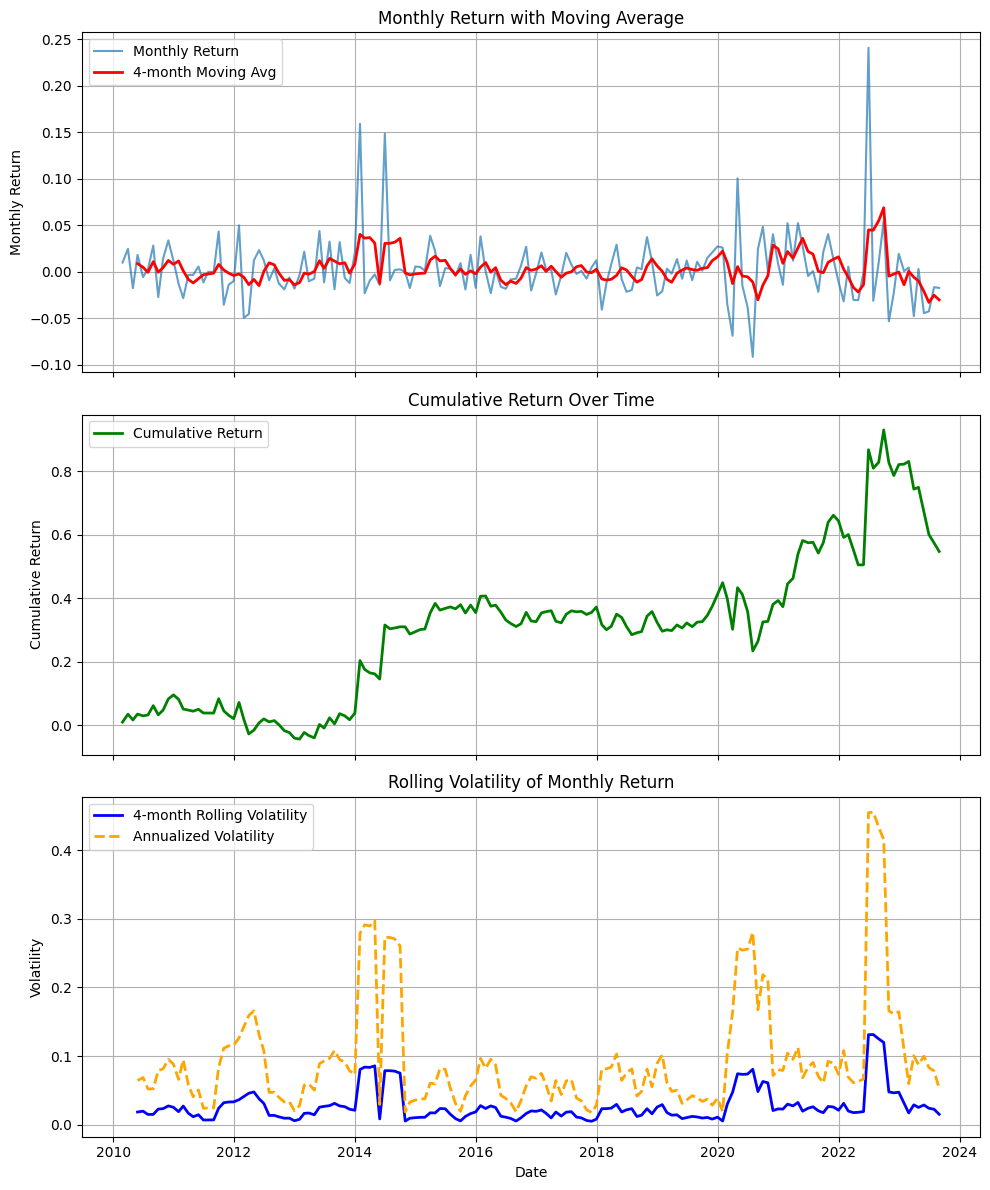

,count,mean,std,min,25%,50%,75%,max
monthly_return,163.000,0.003,0.035,-0.091,-0.014,0.001,0.014,0.241


In [58]:
plot_monthly_pnl(realised_h_strat_returns)

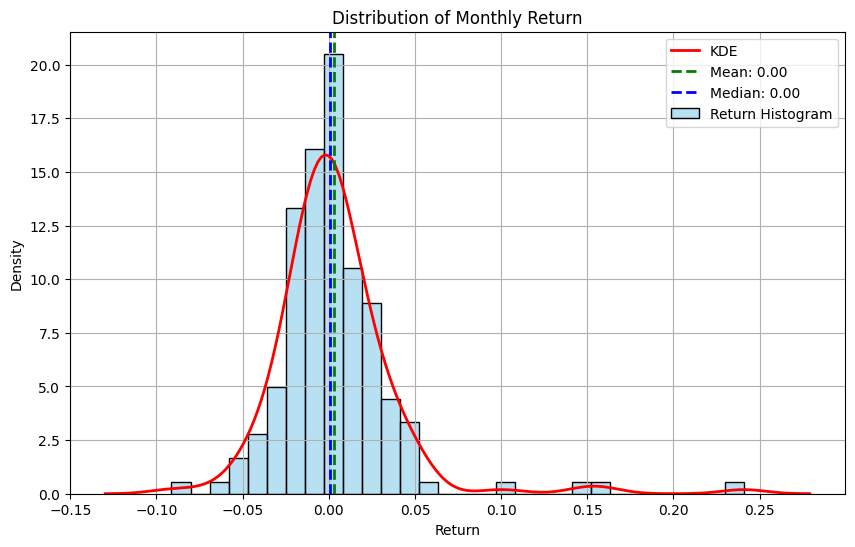

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.06,0.15,-0.06,-0.08,-0.04,-0.05,2.71,14.75


In [59]:
plot_pnl_distribution(realised_h_strat_returns)

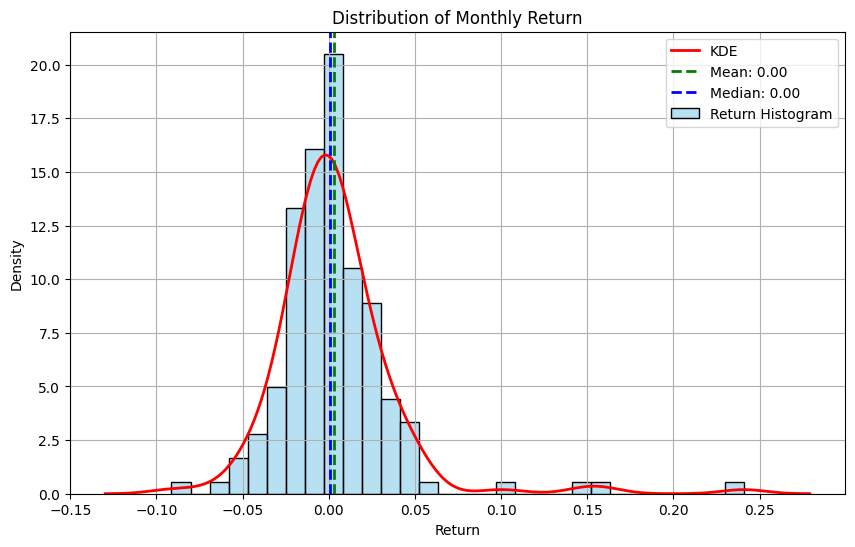

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.06,0.15,-0.06,-0.08,-0.04,-0.05,2.71,14.75


In [60]:
plot_pnl_distribution(realised_h_strat_returns)

### **Performance of portfolios sorted on implied roughness**

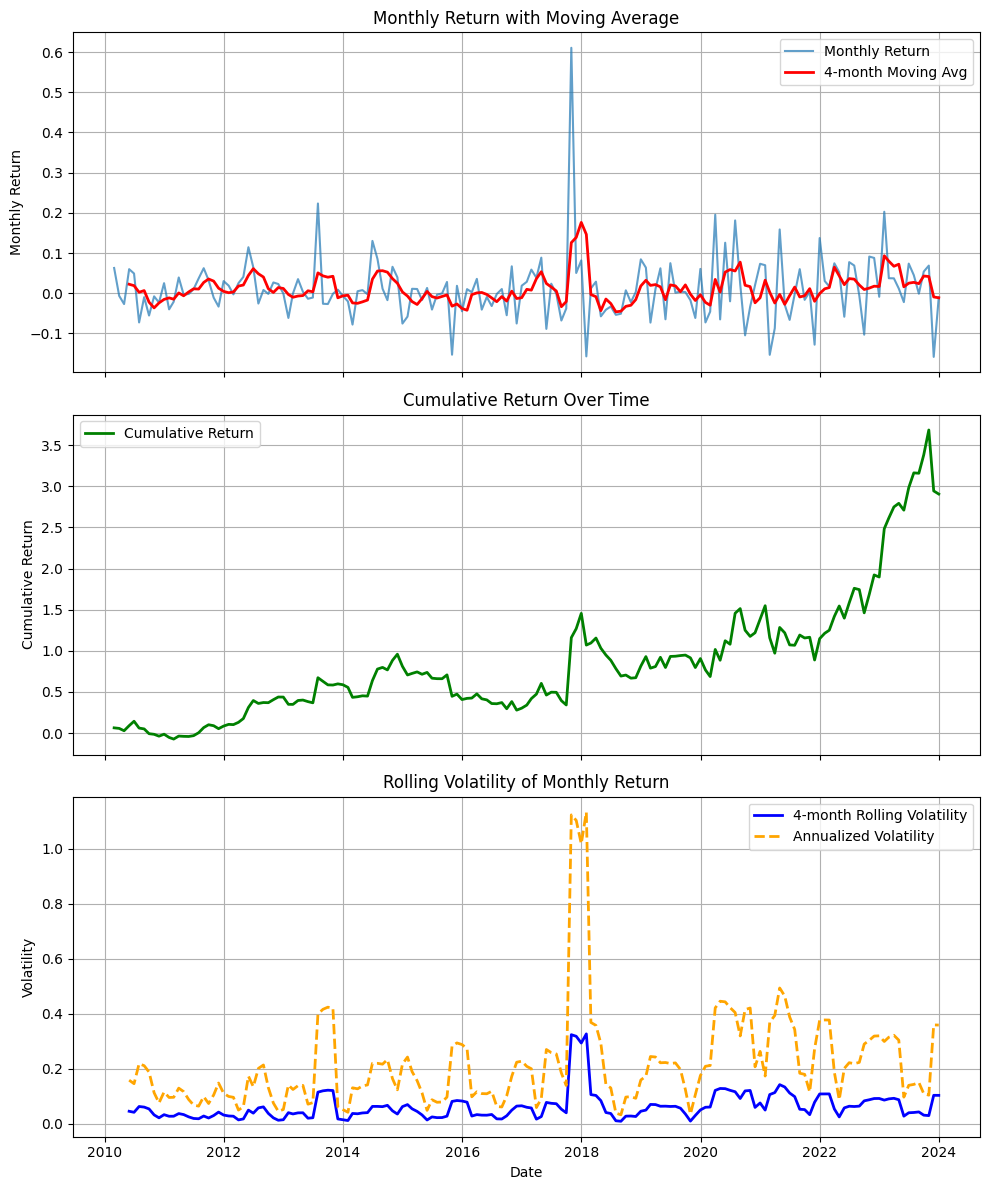

,count,mean,std,min,25%,50%,75%,max
monthly_return,167.000,0.011,0.079,-0.158,-0.026,0.004,0.039,0.611


In [61]:
plot_monthly_pnl(implied_h_strat_returns)

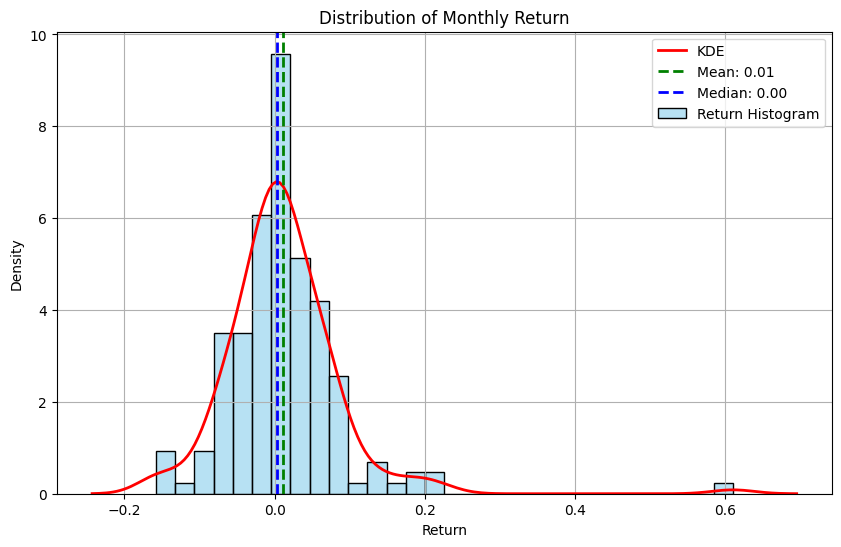

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.15,0.21,-0.15,-0.16,-0.08,-0.13,2.77,19.31


In [62]:
plot_pnl_distribution(implied_h_strat_returns)

In [63]:
calculate_performance_metrics(implied_h_strat_returns)

,Value
Average Monthly Return,0.0109
Std Monthly Return,0.0787
Annualized Sharpe Ratio,0.4817
Annualized Sortino Ratio,0.9564
Maximum Drawdown,-0.7876
Number of Periods,167.0000
Win Ratio (%),52.6946
Profit Factor,1.5662
Max Consecutive Wins,5.0000
Max Consecutive Losses,5.0000
